In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [2]:
from functools import partial

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import jax
import jax.numpy as jnp

import diffrax
import equinox as eqx
import optax

from haiku import PRNGSequence

In [4]:
import exciting_environments as excenvs

import exciting_exciting_systems as eesys
from exciting_exciting_systems.models import NeuralEulerODE
from exciting_exciting_systems.models.model_utils import simulate_ahead_with_env
from exciting_exciting_systems.models.model_training import ModelTrainer
from exciting_exciting_systems.excitation import loss_function, Exciter

from exciting_exciting_systems.utils.density_estimation import (
    update_density_estimate_single_observation, update_density_estimate_multiple_observations, DensityEstimate
)
from exciting_exciting_systems.utils.signals import aprbs
from exciting_exciting_systems.evaluation.plotting_utils import (
    plot_sequence, append_predictions_to_sequence_plot, plot_sequence_and_prediction, plot_model_performance
)

---

In [5]:
class FluidTank(excenvs.core_env.CoreEnvironment):
    """Fluid tank based on torricelli's principle.
    
    Based on ex. 7.3.2 on p. 355 of "System Dynamics" from Palm, William III.
    """

    def __init__(
        self,
        batch_size: float = 1,
        base_area: float = jnp.pi,
        orifice_area: float = jnp.pi * 0.1**2,
        c_d: float = 0.6,  # typical value for water [Palm2010]
        max_inflow: float = 0.2,
        reward_func=None,
        tau=1e-3,
        constraints=(3,)
    ):
        self.static_params = {
            "base_area": base_area,
            "orifice_area": orifice_area,
            "c_d": c_d,
        }
        self.env_state_constraints = [constraints[0]]
        self.env_state_initials = [0.5]
        self.max_action = [max_inflow]

        super().__init__(batch_size=batch_size, tau=tau, reward_func=reward_func)
        self.static_params, self.env_state_normalizer, self.action_normalizer, self.env_observation_space, self.action_space = self.sim_paras(
            self.static_params, self.env_state_constraints, self.max_action)

    @partial(jax.jit, static_argnums=0)
    def _ode_exp_euler_step(self, states_norm, inflow_norm, env_state_normalizer, action_normalizer, static_params):
        env_states_norm = states_norm
        inflow = inflow_norm*action_normalizer
        env_states = env_state_normalizer * env_states_norm
        extra_args = (inflow, static_params)

        def vector_field(t, y, args):
            h = y[0]
            inflow, params = args
            g = 9.81
            
            dh_dt = inflow / params["base_area"] - params["c_d"] * params["orifice_area"] / params["base_area"] * jnp.sqrt(2*g*h)
            return (dh_dt, )

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.tau
        y0 = (env_states, )

        env_state = self._solver.init(term, t0, t1, y0, extra_args)
        y, _, _, env_state, _ = self._solver.step(
            term, t0, t1, y0, extra_args, env_state, made_jump=False
        )

        h_k1 = y[0]

        env_states_k1_norm = h_k1 / env_state_normalizer
        return env_states_k1_norm

    @partial(jax.jit, static_argnums=0)
    def default_reward_func(self, obs, action):
        return 0

    @partial(jax.jit, static_argnums=0)
    def generate_observation(self, states):
        """Returns states."""
        return states
    
    @partial(jax.jit, static_argnums=0)
    def generate_truncated(self, states):
        """Returns states."""
        return 0

    @partial(jax.jit, static_argnums=0)
    def generate_terminated(self, states, reward):
        """Returns states."""
        return False

    @property
    def obs_description(self):
        return self.states_description

    @property
    def states_description(self):
        return np.array(["fluid height"])

    @property
    def action_description(self):
        return np.array(["inflow"])

In [6]:
# setup PRNG
key = jax.random.PRNGKey(seed=33) # 21)

data_key, model_key, loader_key, key = jax.random.split(key, 4)
data_rng = PRNGSequence(data_key)

In [7]:
batch_size = 1
tau = 5e-1 # 5e-2

env = FluidTank(
    batch_size=1,
    tau=tau
)

In [8]:
obs, state = env.reset()
obs = obs.astype(jnp.float32)
state = state.astype(jnp.float32)
n_steps = 999

actions = aprbs(n_steps, batch_size, 1, 10, next(data_rng))

actions = (actions + 1) / 2

actions.shape: (1, 999, 1)
observations.shape: (1, 1000, 1)
 
 One of the trajectories:


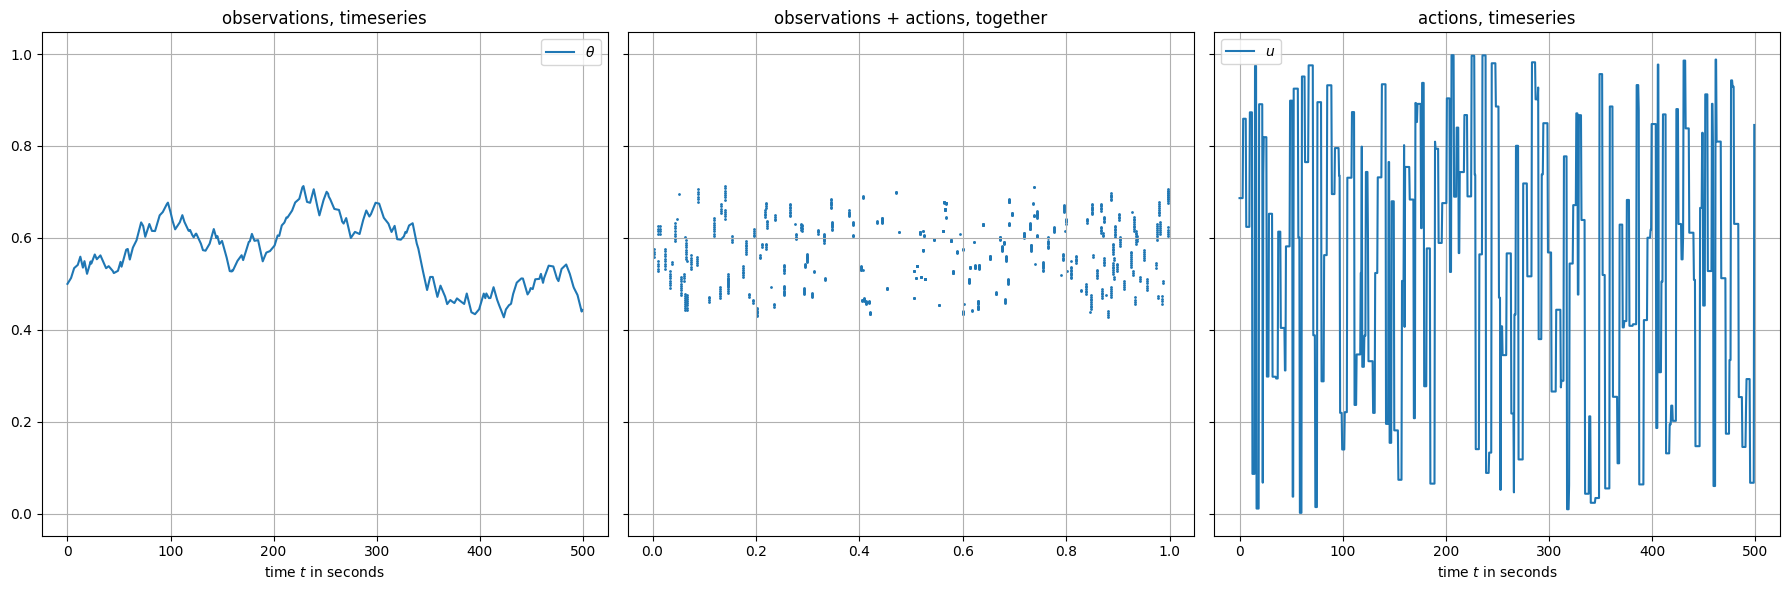

In [9]:
observations = jax.vmap(simulate_ahead_with_env, in_axes=(None, 0, 0, 0, 0, 0, 0))(
    env,
    obs,
    state,
    actions,
    env.env_state_normalizer,
    env.action_normalizer,
    env.static_params
)

print("actions.shape:", actions.shape)
print("observations.shape:", observations.shape)

print(" \n One of the trajectories:")
fig, axs = plot_sequence(
    observations=observations[0, ...],
    actions=actions[0, ...],
    tau=tau,
    obs_labels=[r"$\theta$", r"$\omega$"],
    action_labels=[r"$u$"],
);
plt.show()

---

In [39]:
bandwidth = 0.01
n_prediction_steps = 50

dim = 2
points_per_dim = 50
n_grid_points=points_per_dim**dim

n_timesteps = 15_000

In [40]:
obs, state = env.reset()
obs = obs.astype(jnp.float32)
state = state.astype(jnp.float32)

observations = jnp.zeros((n_timesteps, env.env_observation_space.shape[-1]))
observations = observations.at[0].set(obs[0])
actions = jnp.zeros((n_timesteps-1, env.action_space.shape[-1]))

proposed_actions = aprbs(n_prediction_steps, batch_size, 1, 10, next(data_rng))
proposed_actions = (proposed_actions + 1) / 2  # remap from (-1, 1) to (0, 1)

In [41]:
exciter = Exciter(
    grad_loss_function=jax.grad(loss_function, argnums=(3)),
    excitation_optimizer=optax.adabelief(1e-1),
    tau=tau,
    target_distribution=jnp.ones(shape=(n_grid_points, 1)) * 1 / (env.env_observation_space.high)**dim  # transposed pdf_vectorfield instead as a test
)

model_trainer = ModelTrainer(
    start_learning=n_prediction_steps,
    training_batch_size=32,
    n_train_steps=2,
    sequence_length=n_prediction_steps,
    featurize=lambda obs: obs,
    model_optimizer=optax.adabelief(1e-4),
    tau=tau
)

density_estimate = DensityEstimate(
    p=jnp.zeros([batch_size, n_grid_points, 1]),
    x_g=eesys.utils.density_estimation.build_grid_2d(
        low=0,
        high=env.env_observation_space.high,
        points_per_dim=points_per_dim
    ),
    bandwidth=jnp.array([bandwidth]),
    n_observations=jnp.array([0])
)

model = NeuralEulerODE(
    obs_dim=env.env_observation_space.shape[-1],
    action_dim=env.action_space.shape[-1],
    width_size=128,
    depth=3,
    key=model_key
)

opt_state_model = model_trainer.model_optimizer.init(eqx.filter(model, eqx.is_inexact_array))

In [42]:
from exciting_exciting_systems.algorithms import excite_and_fit

  0%|          | 0/15000 [00:00<?, ?it/s]

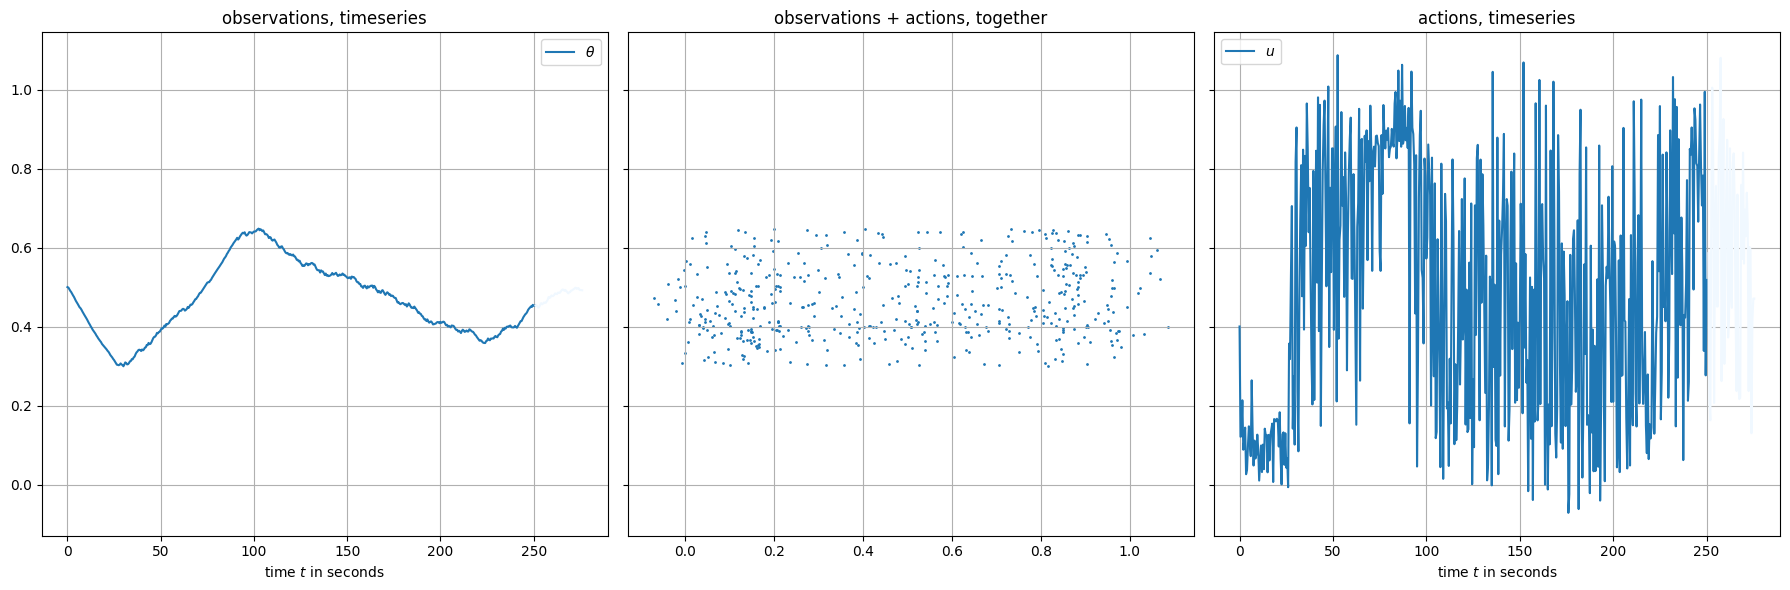

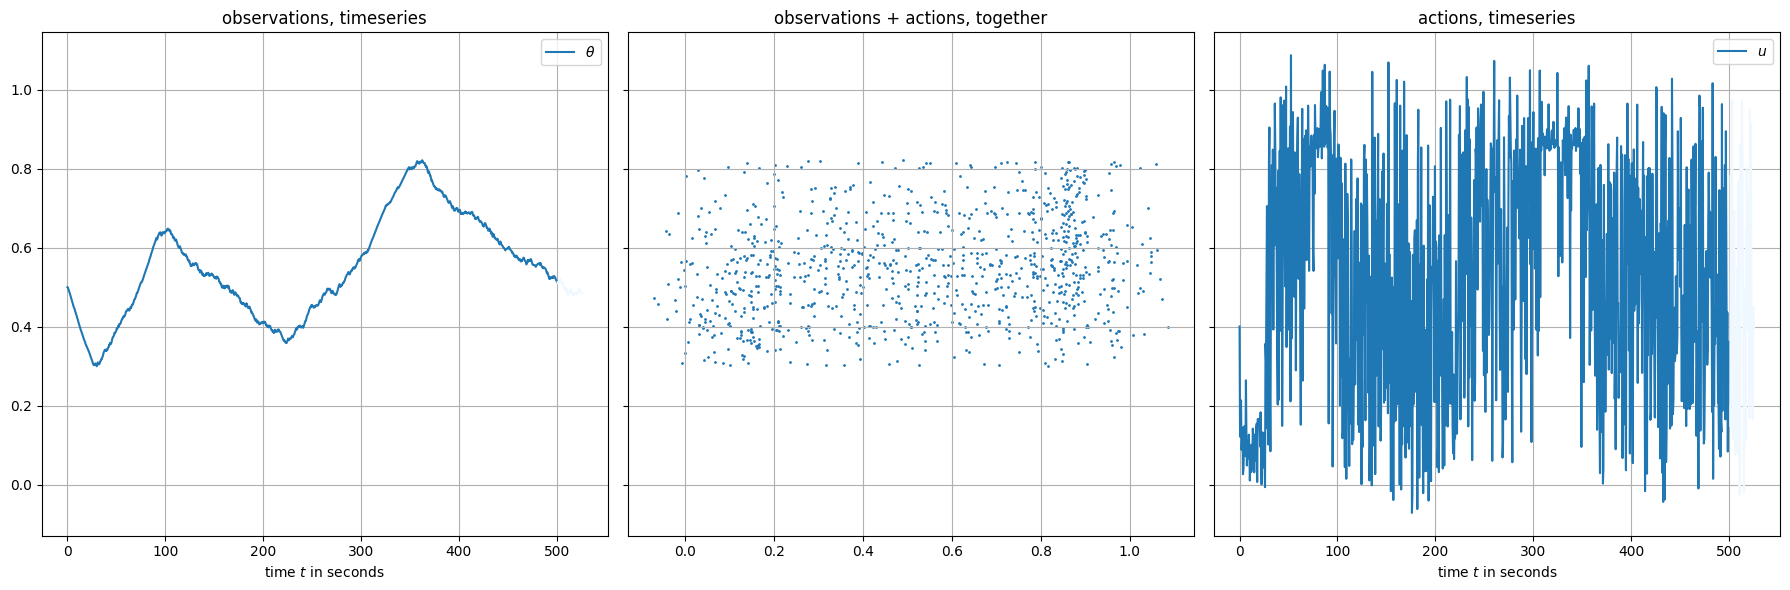

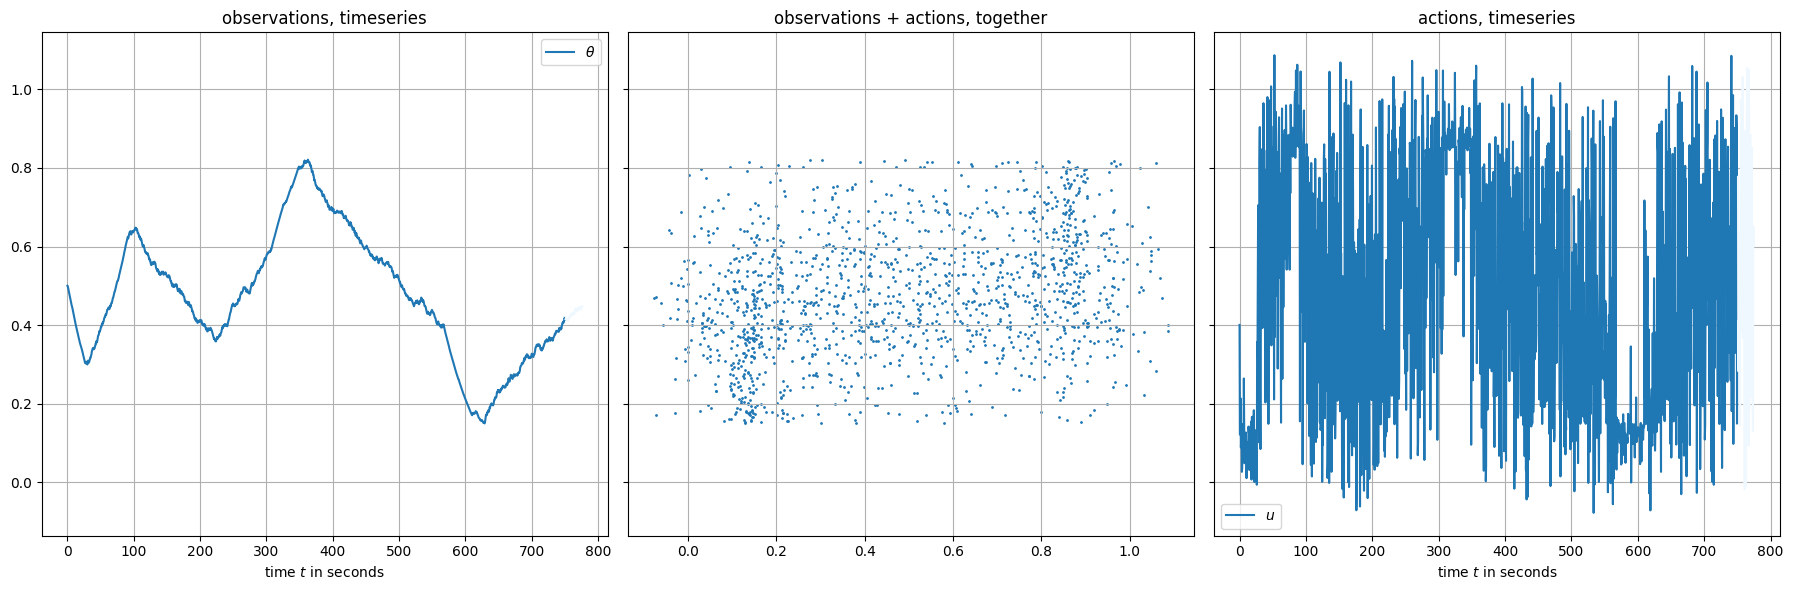

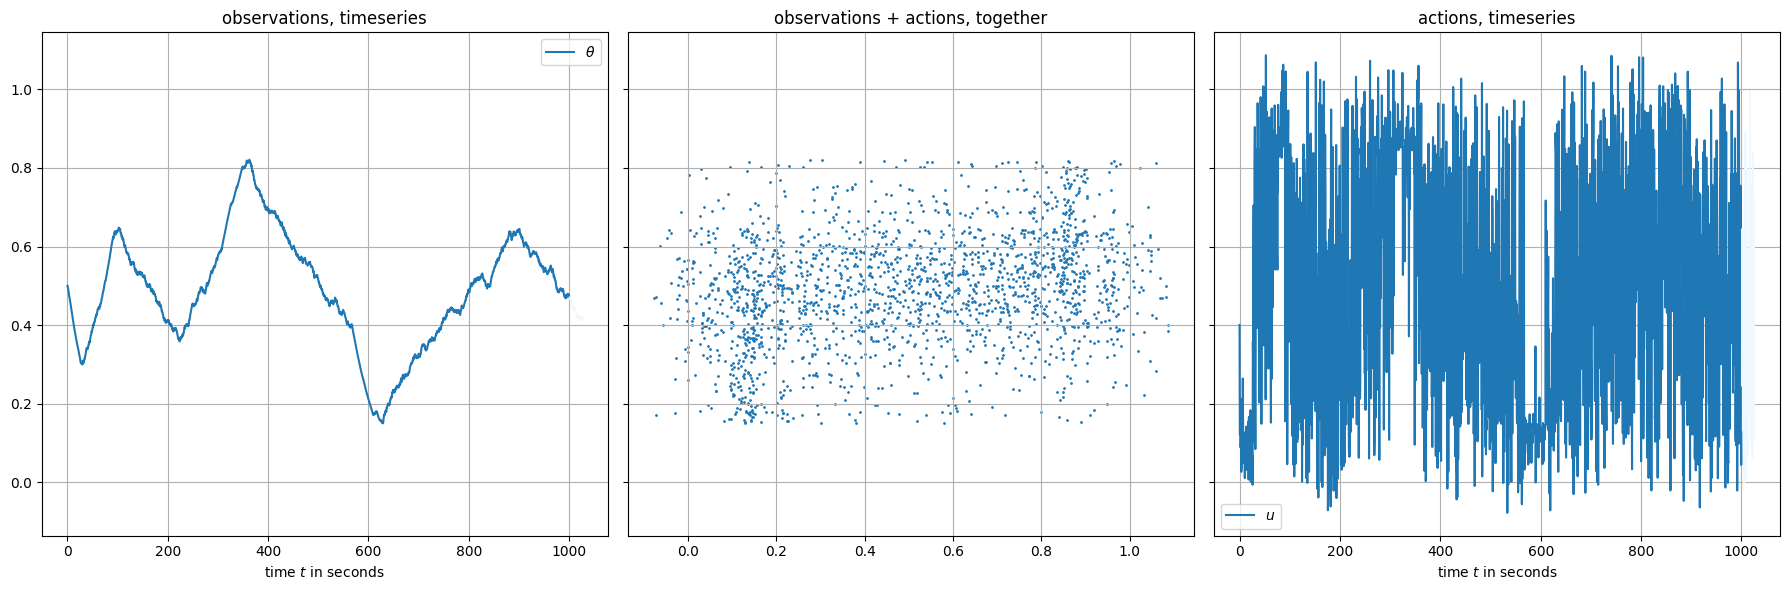

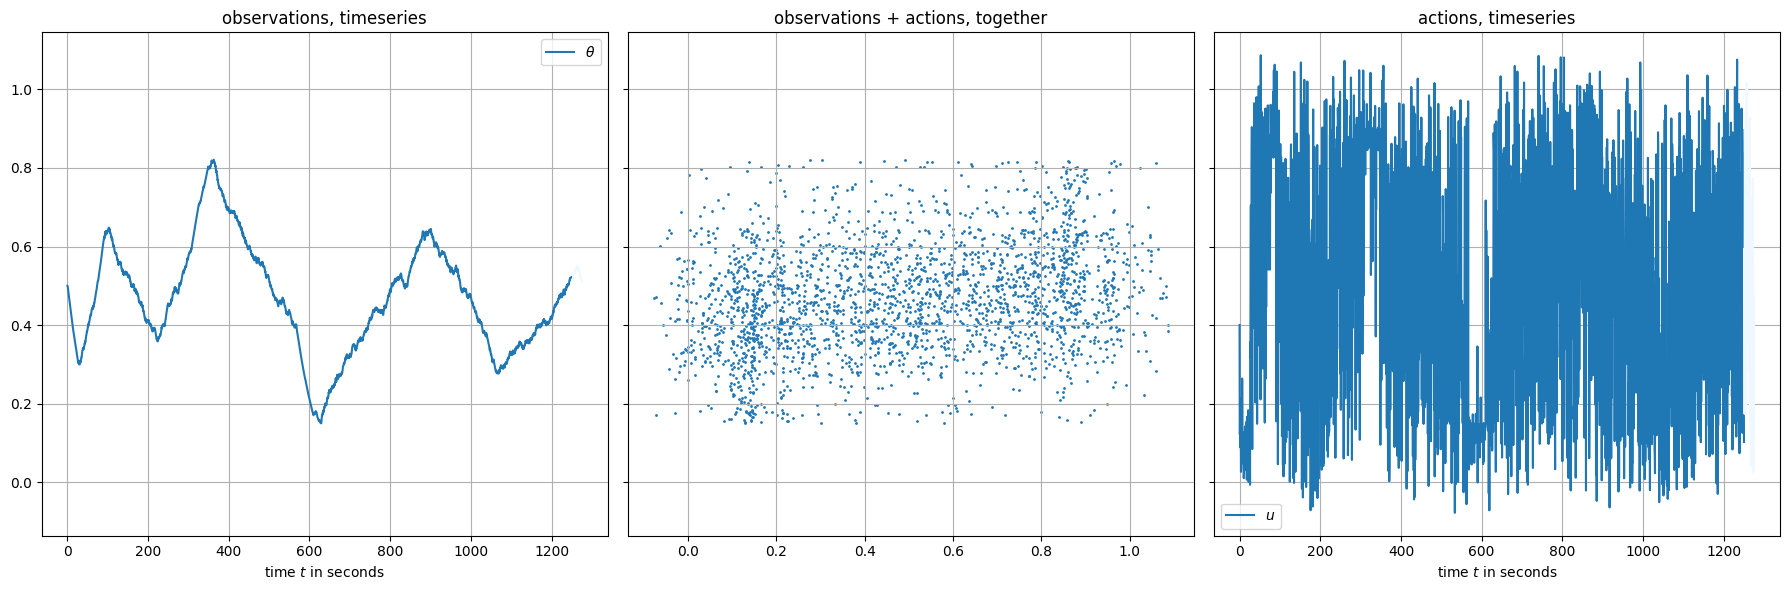

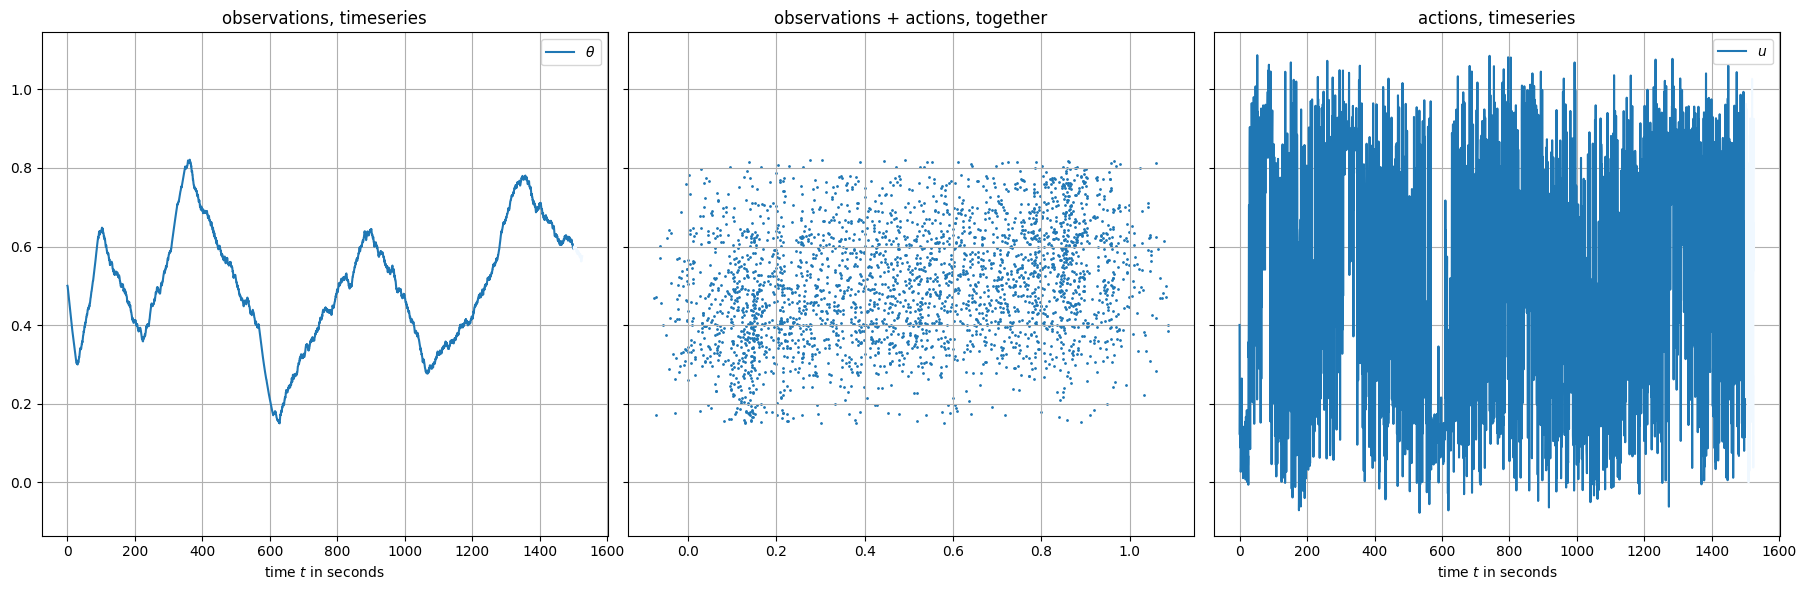

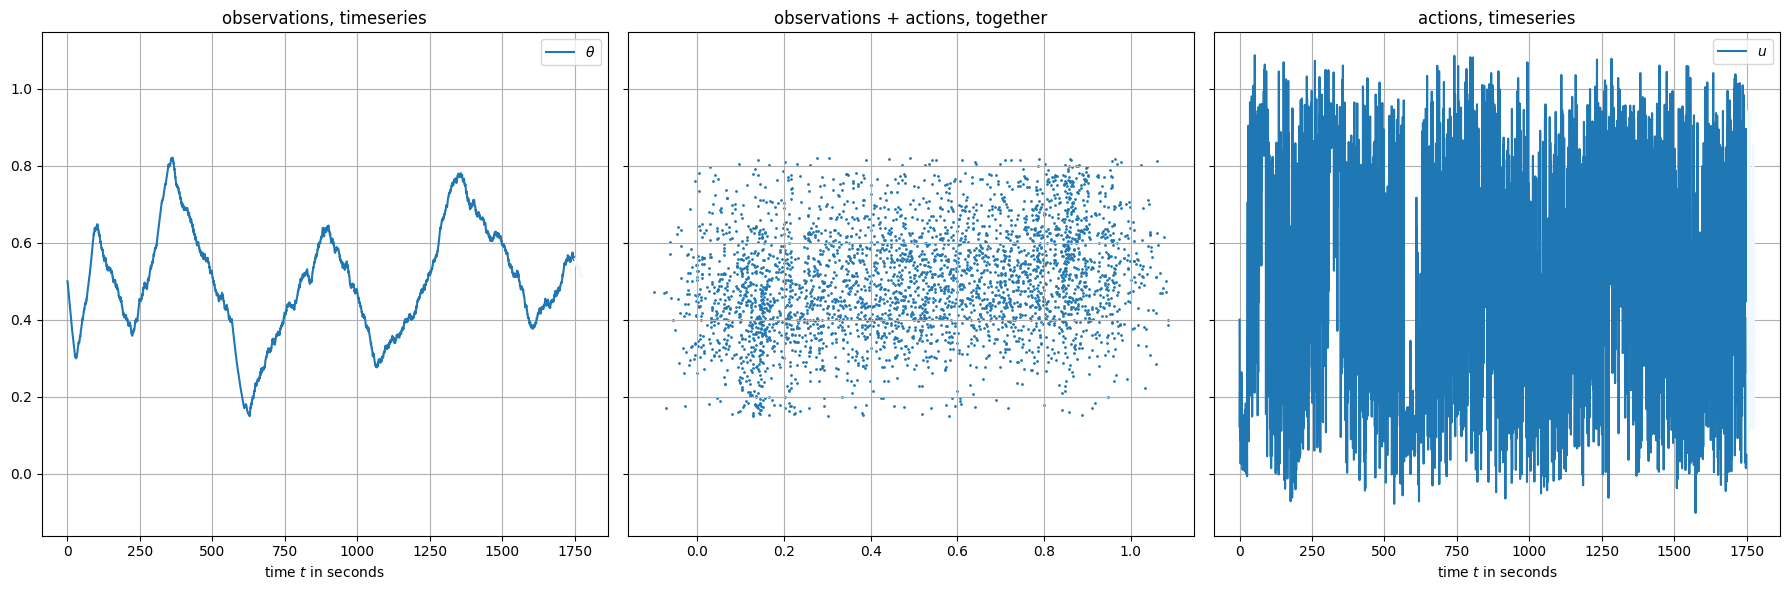

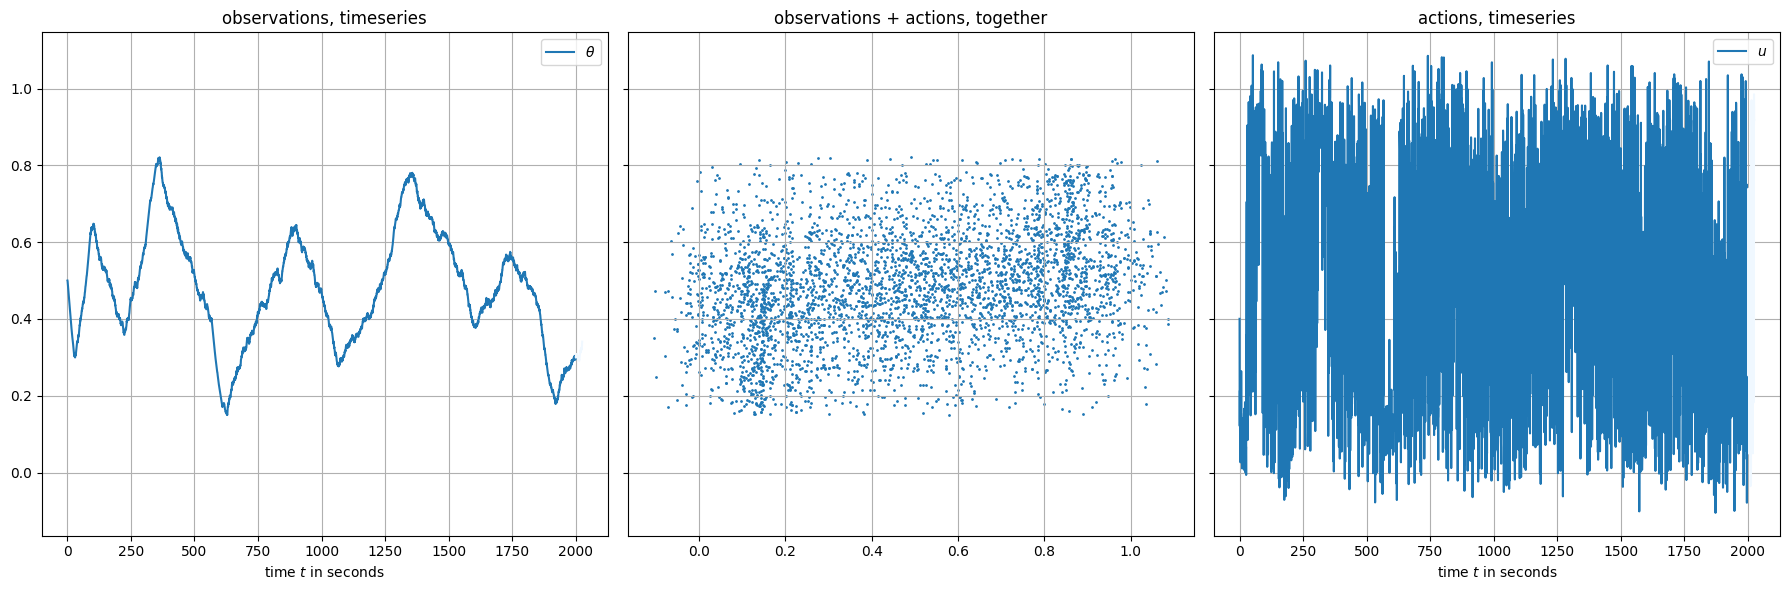

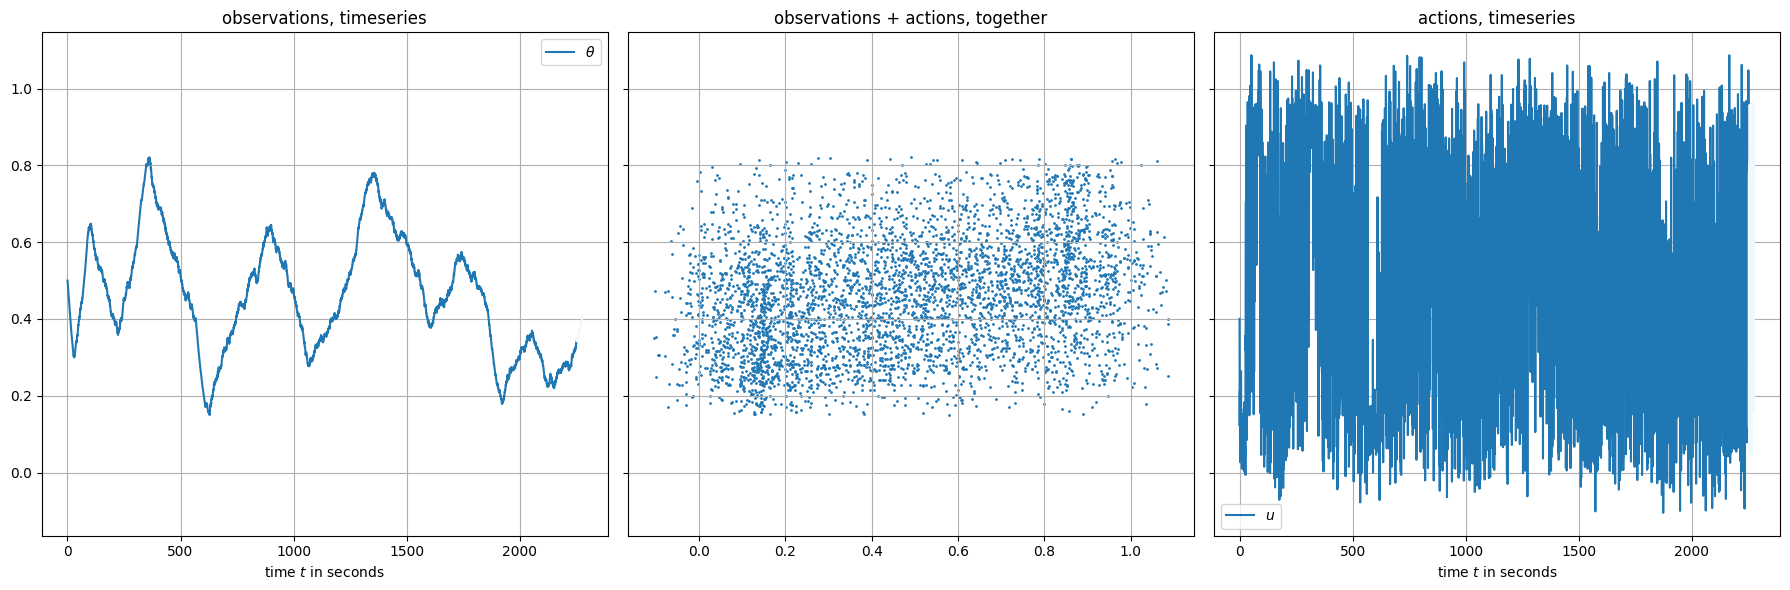

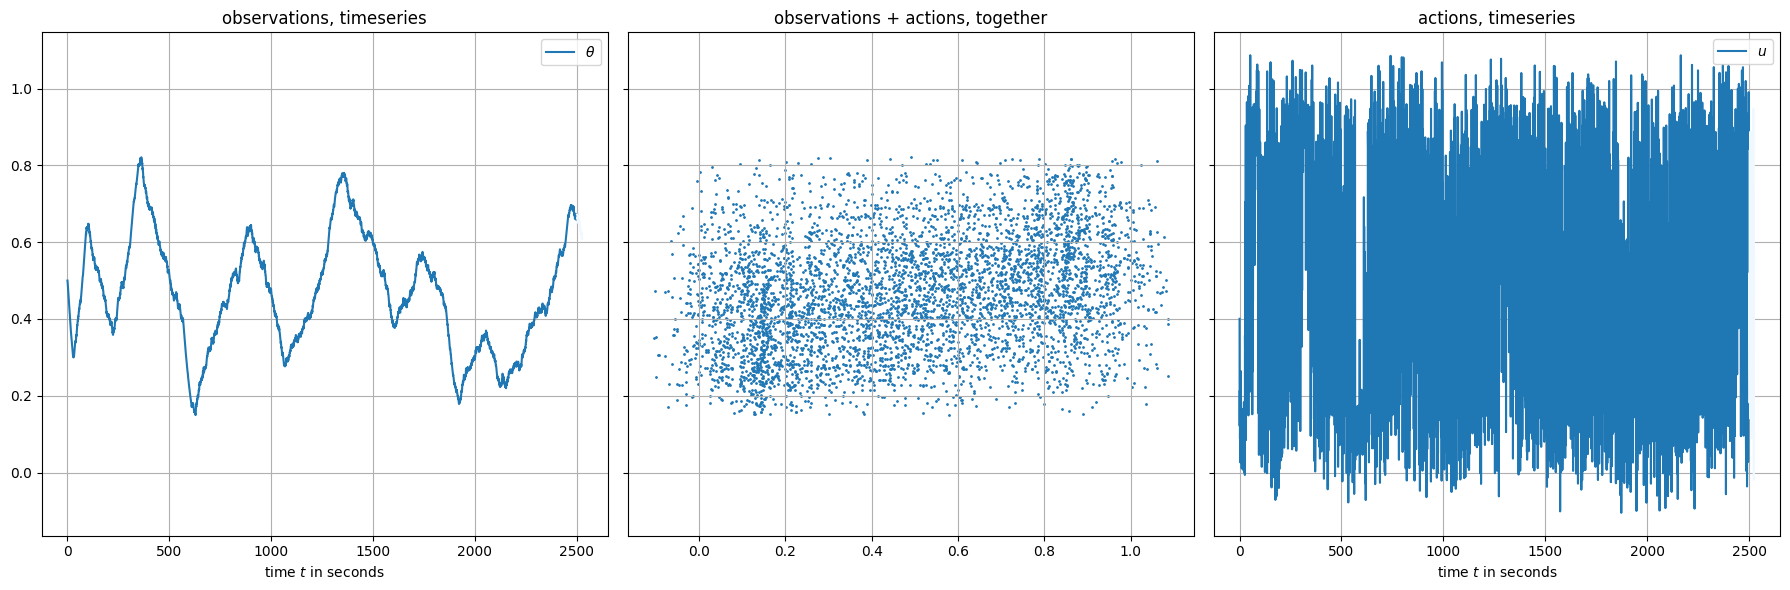

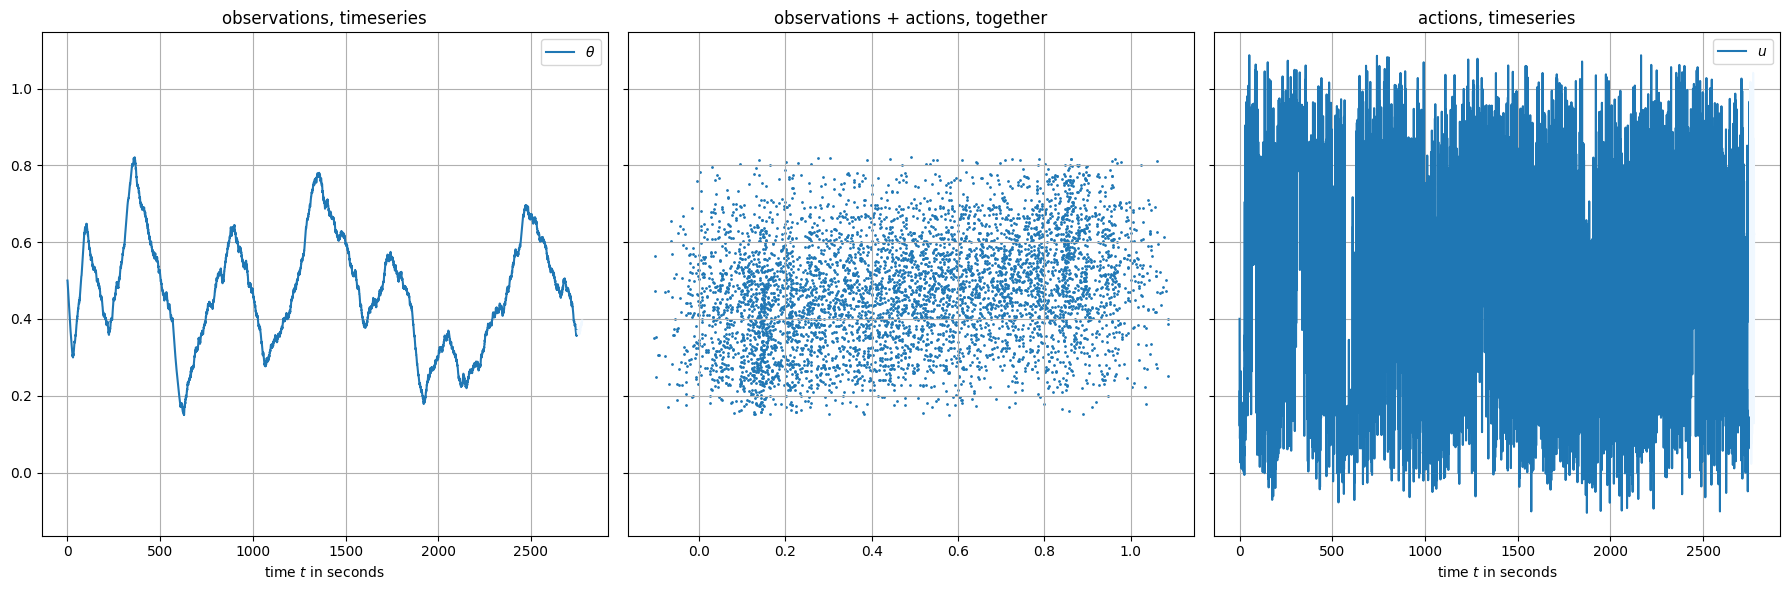

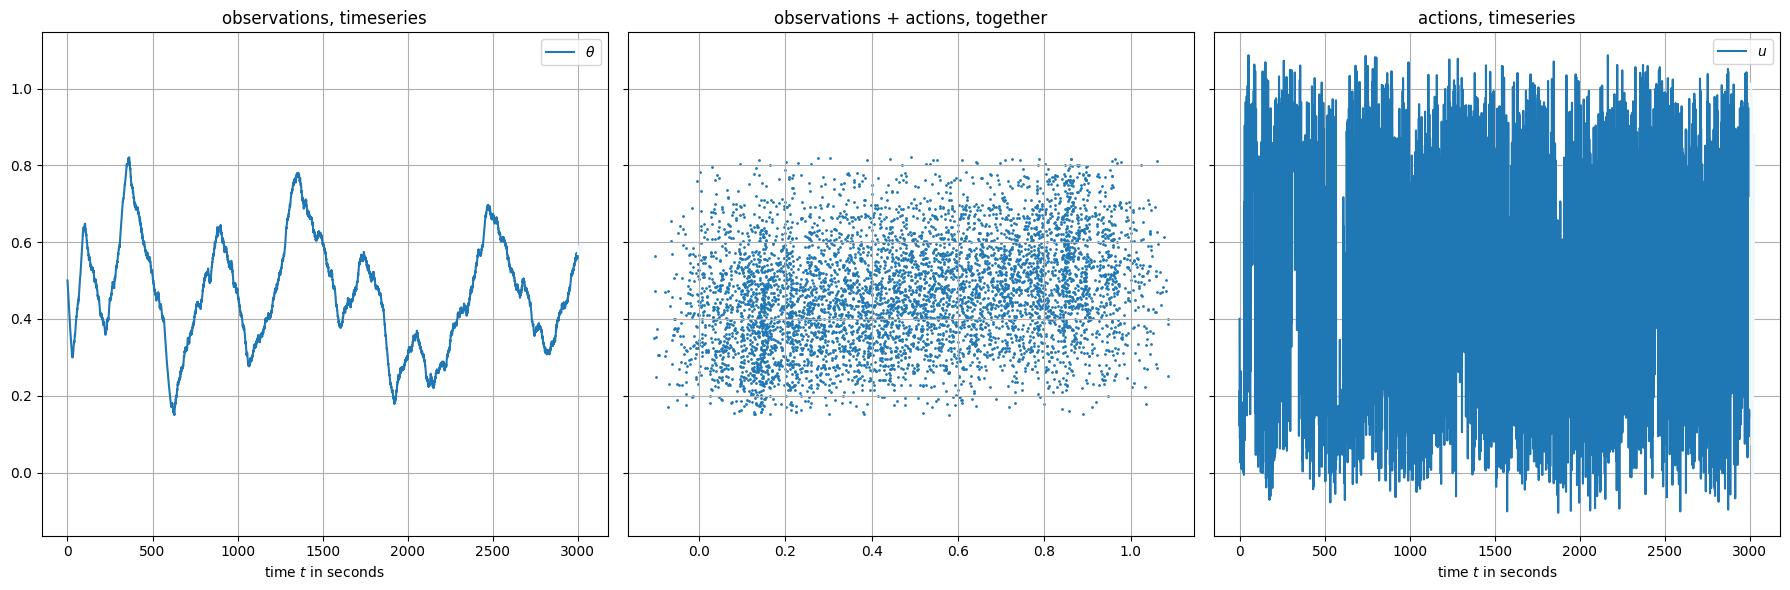

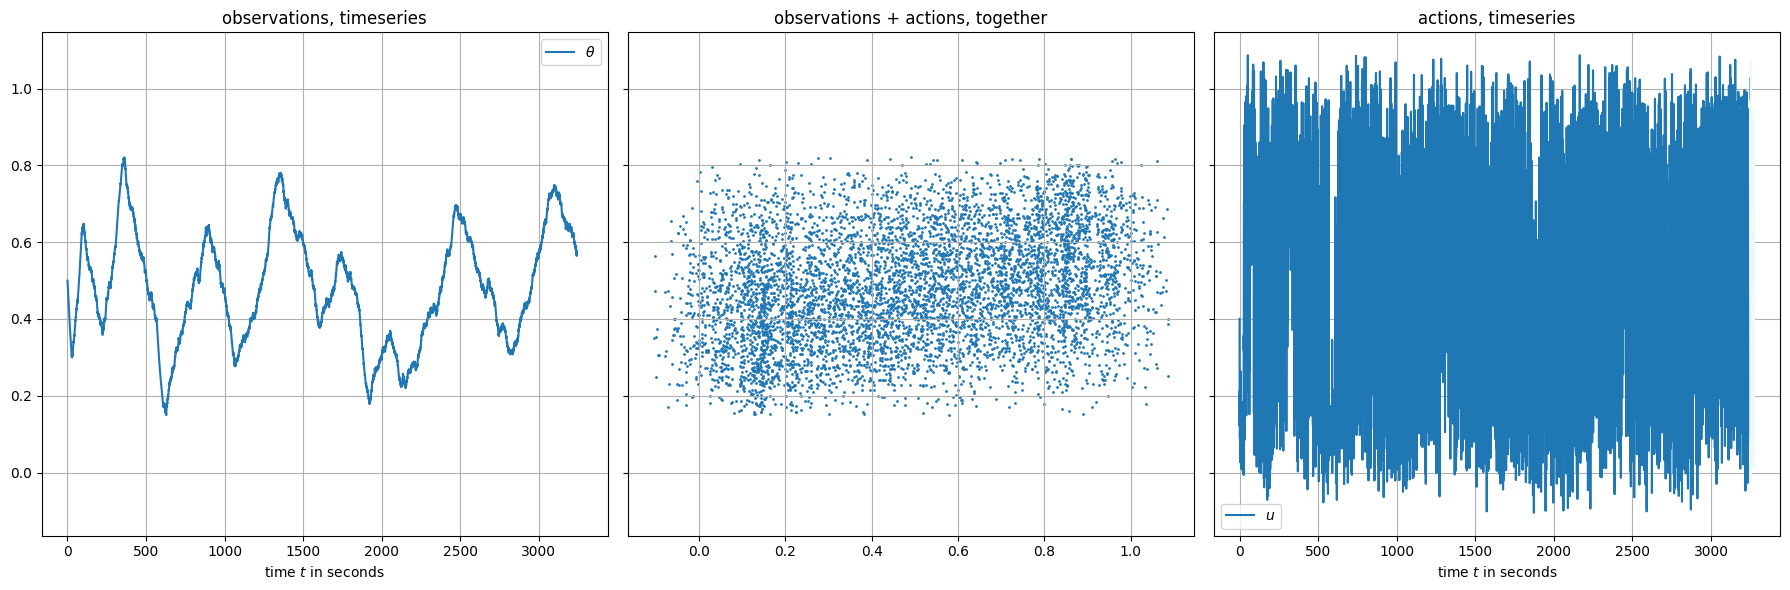

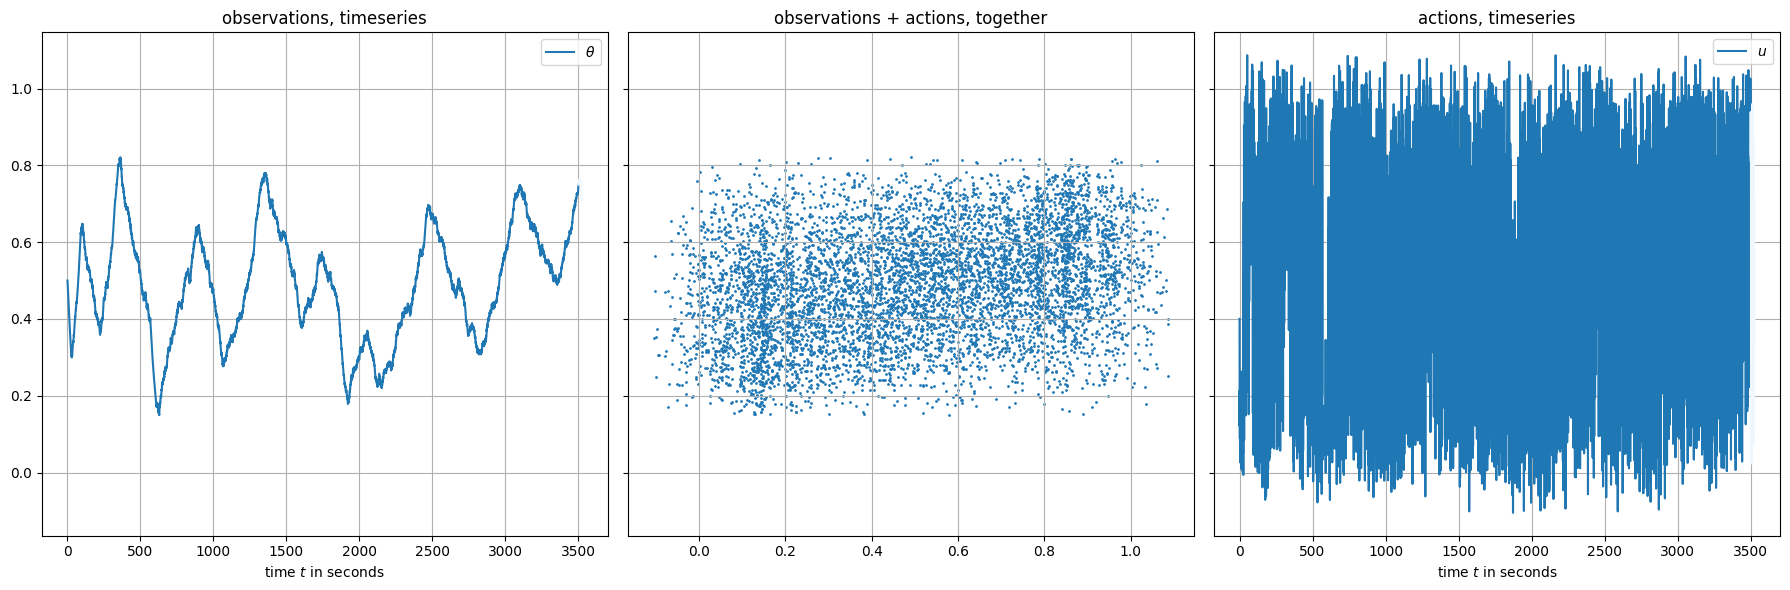

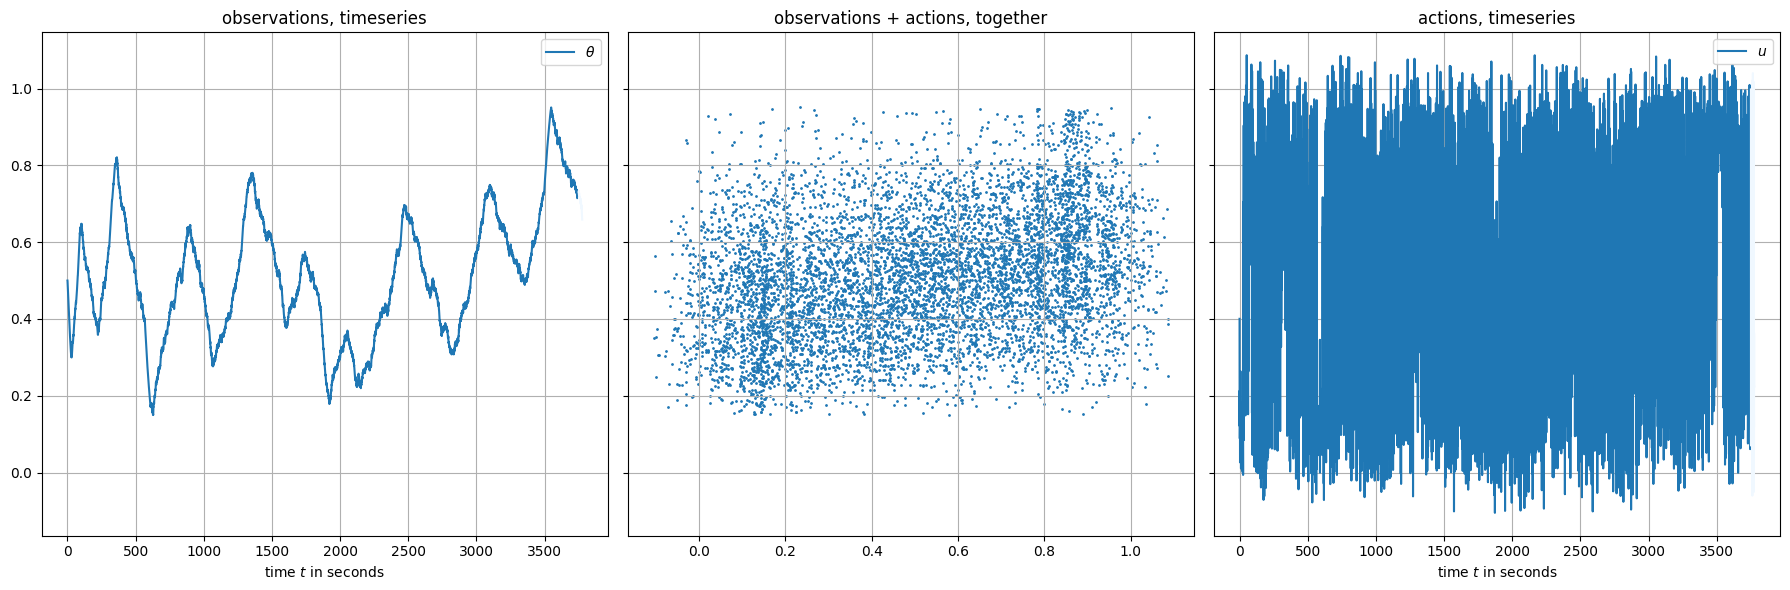

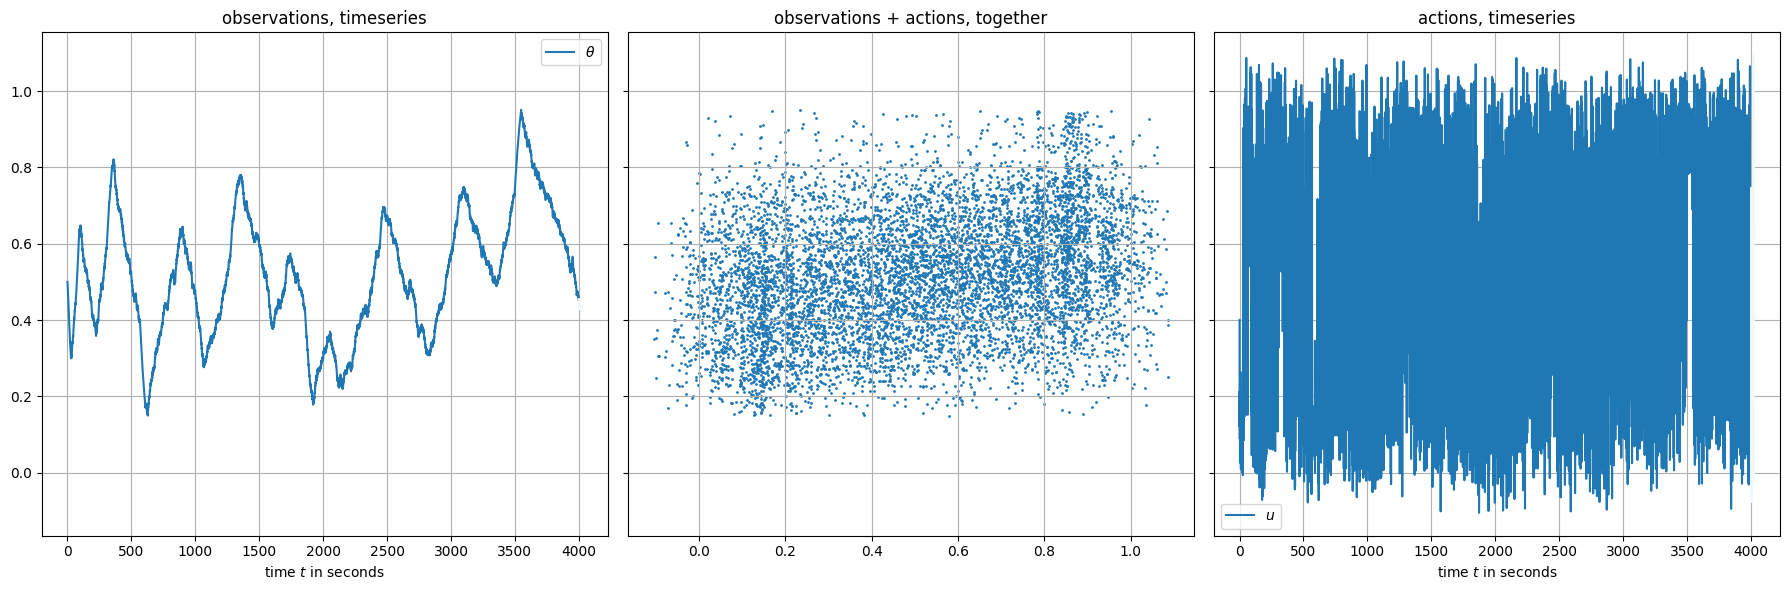

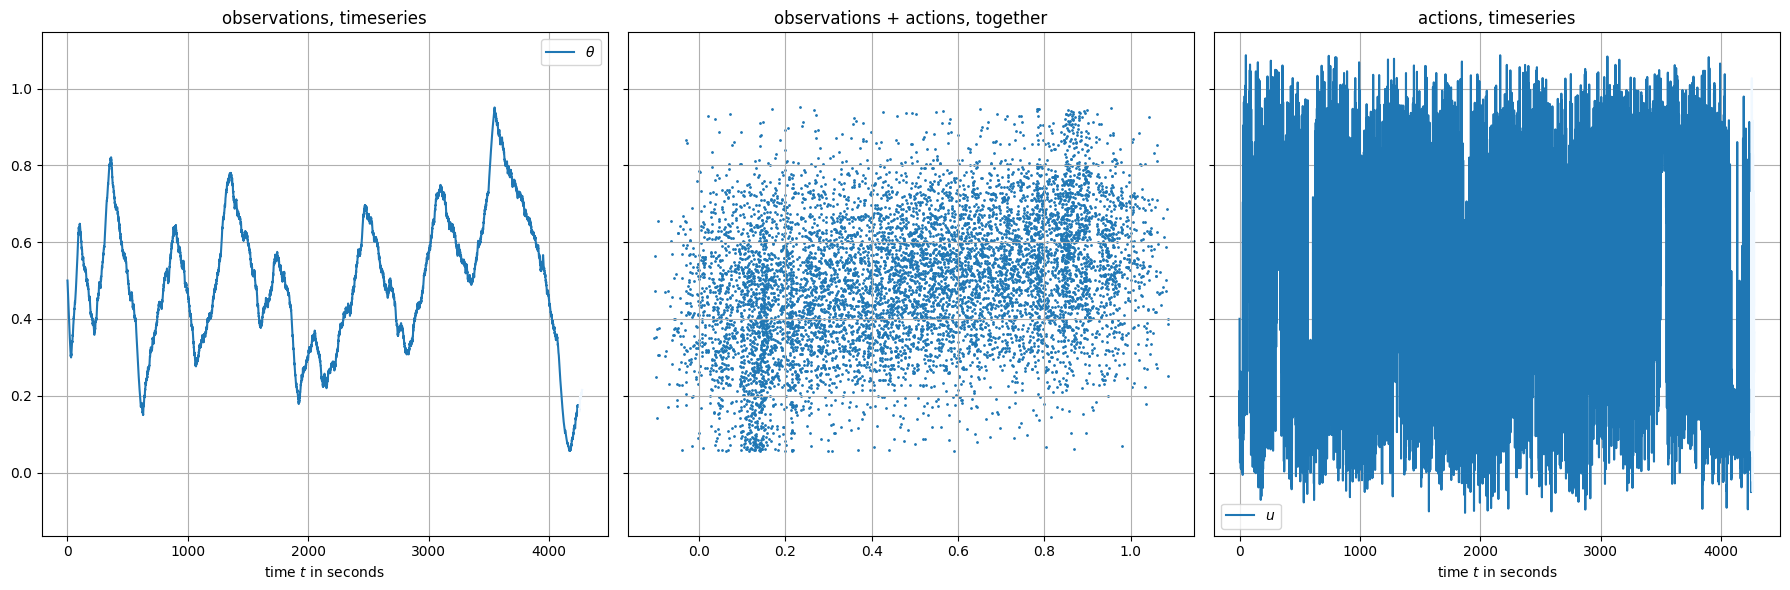

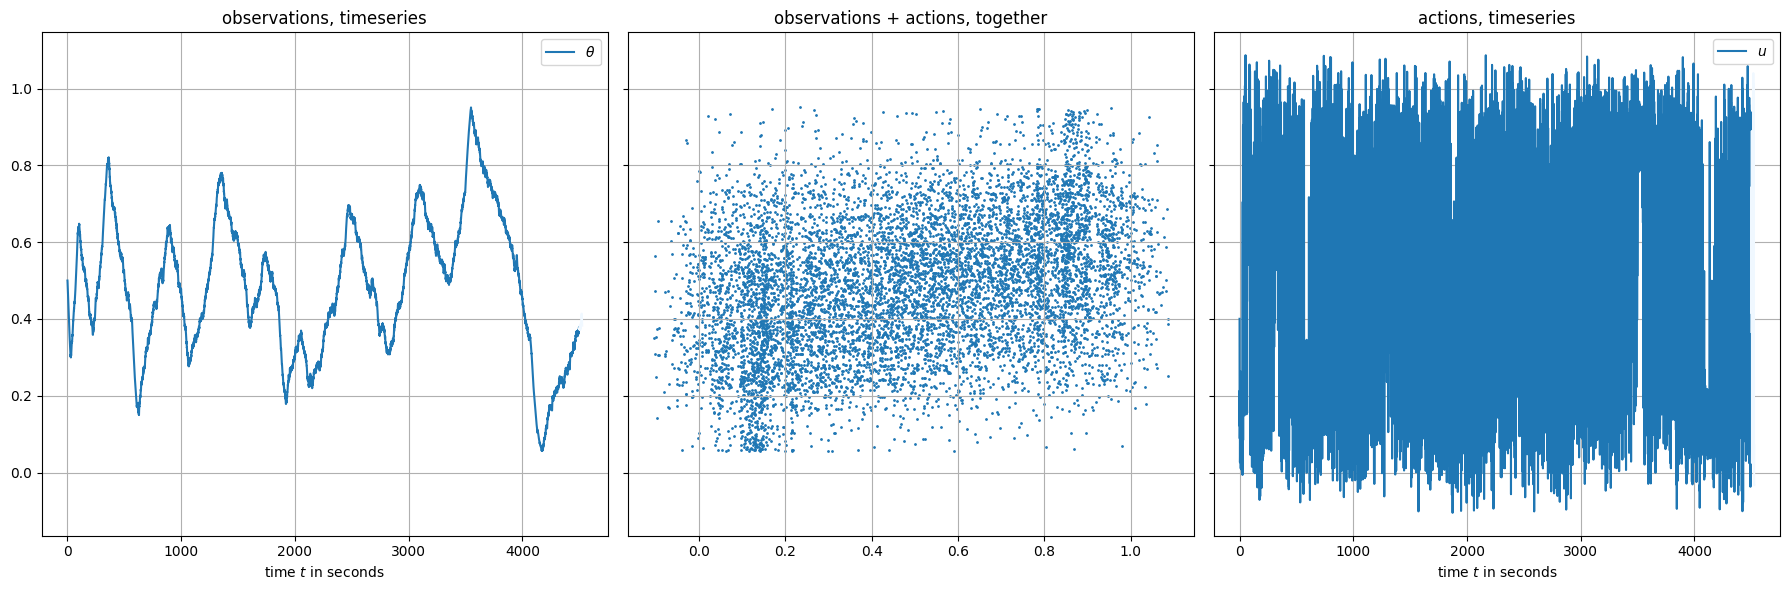

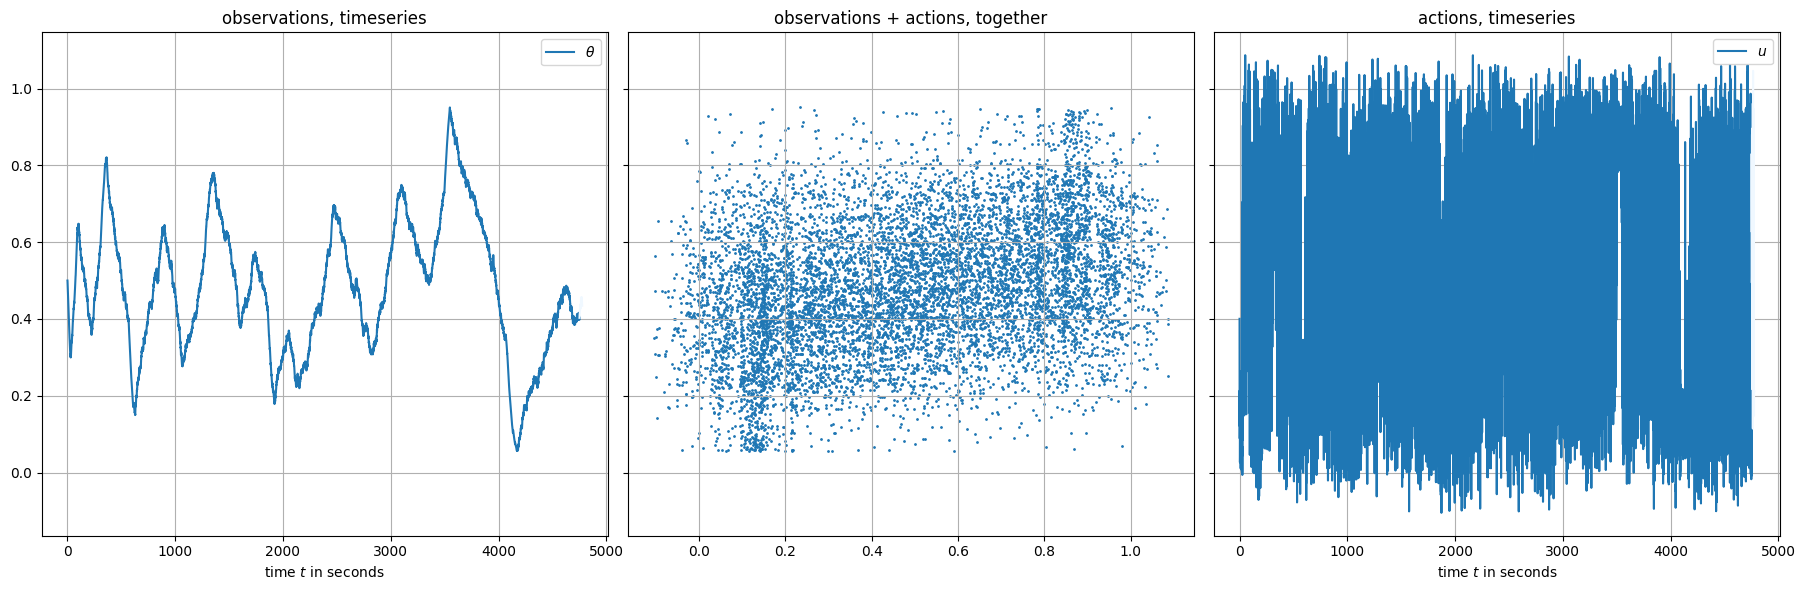

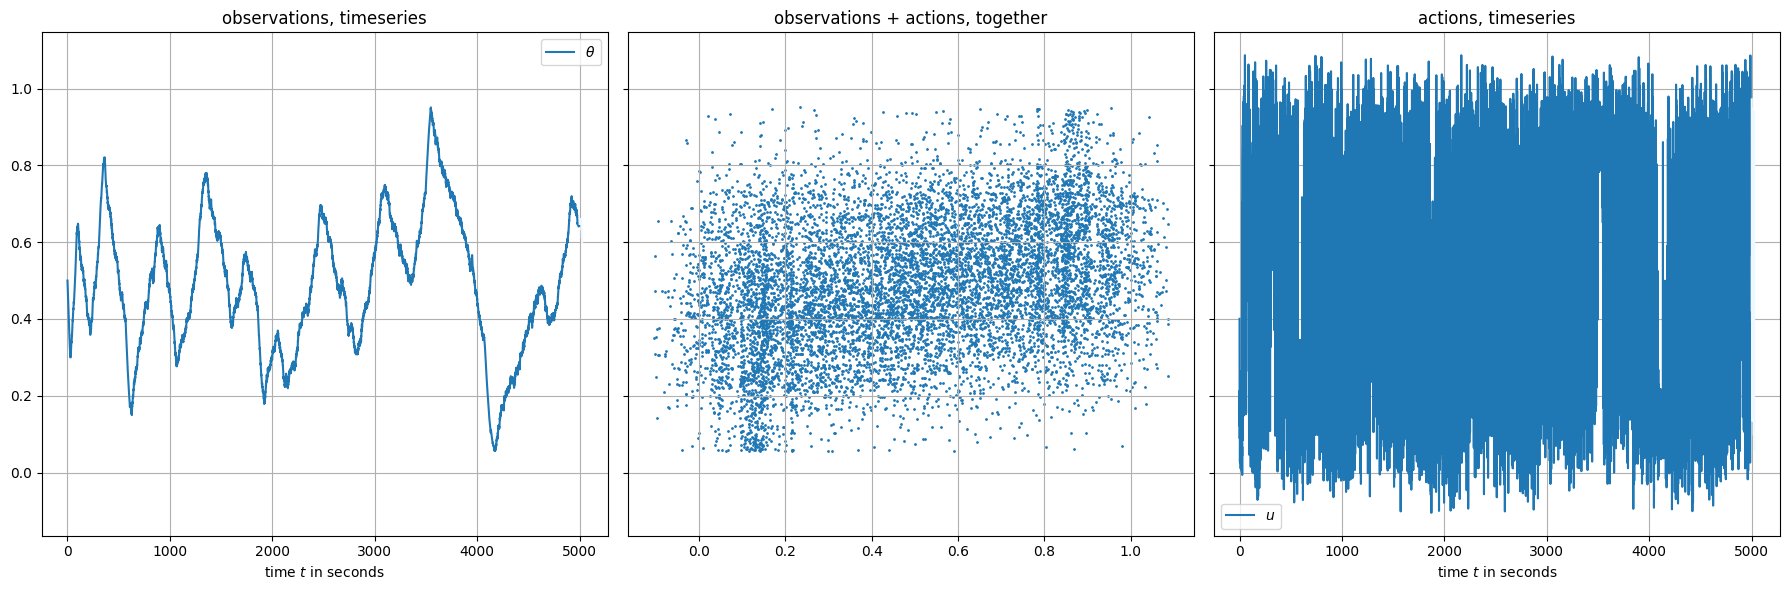

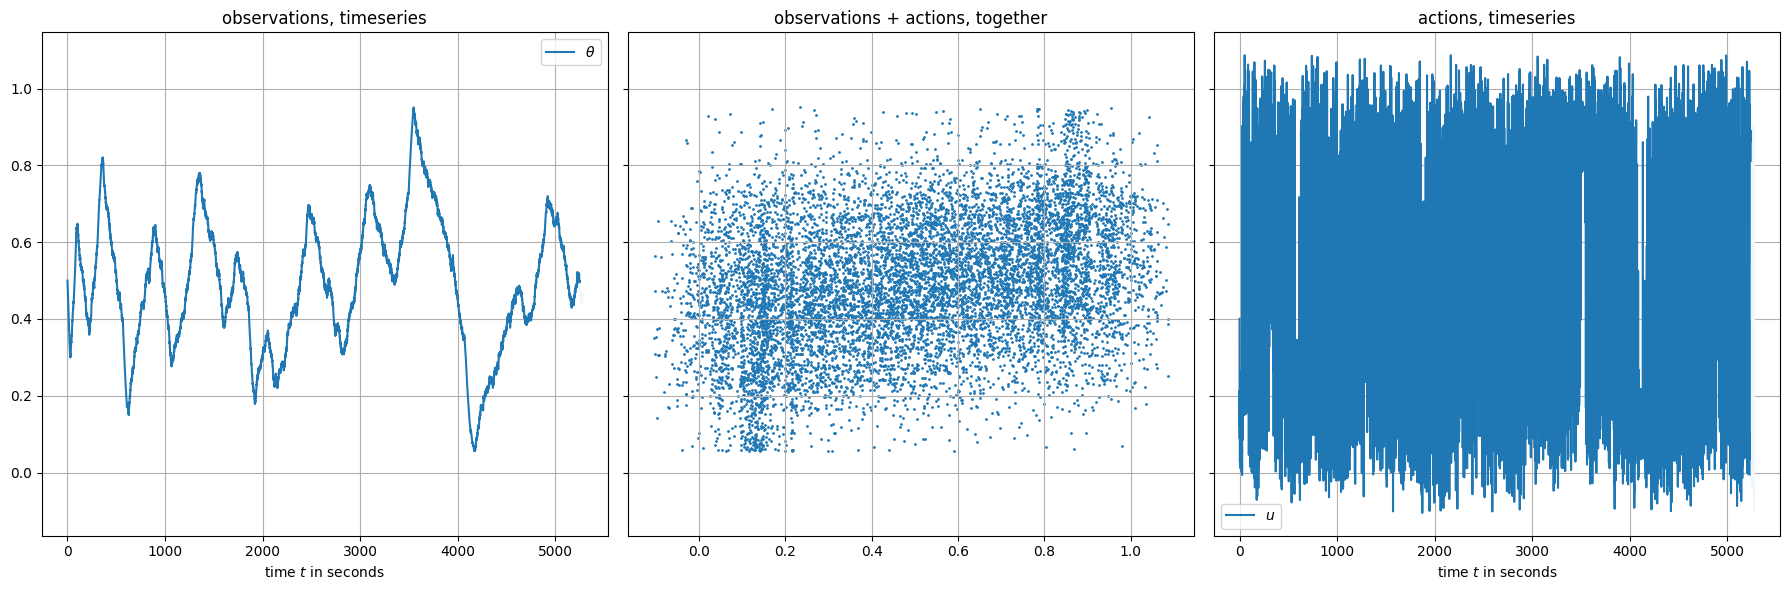

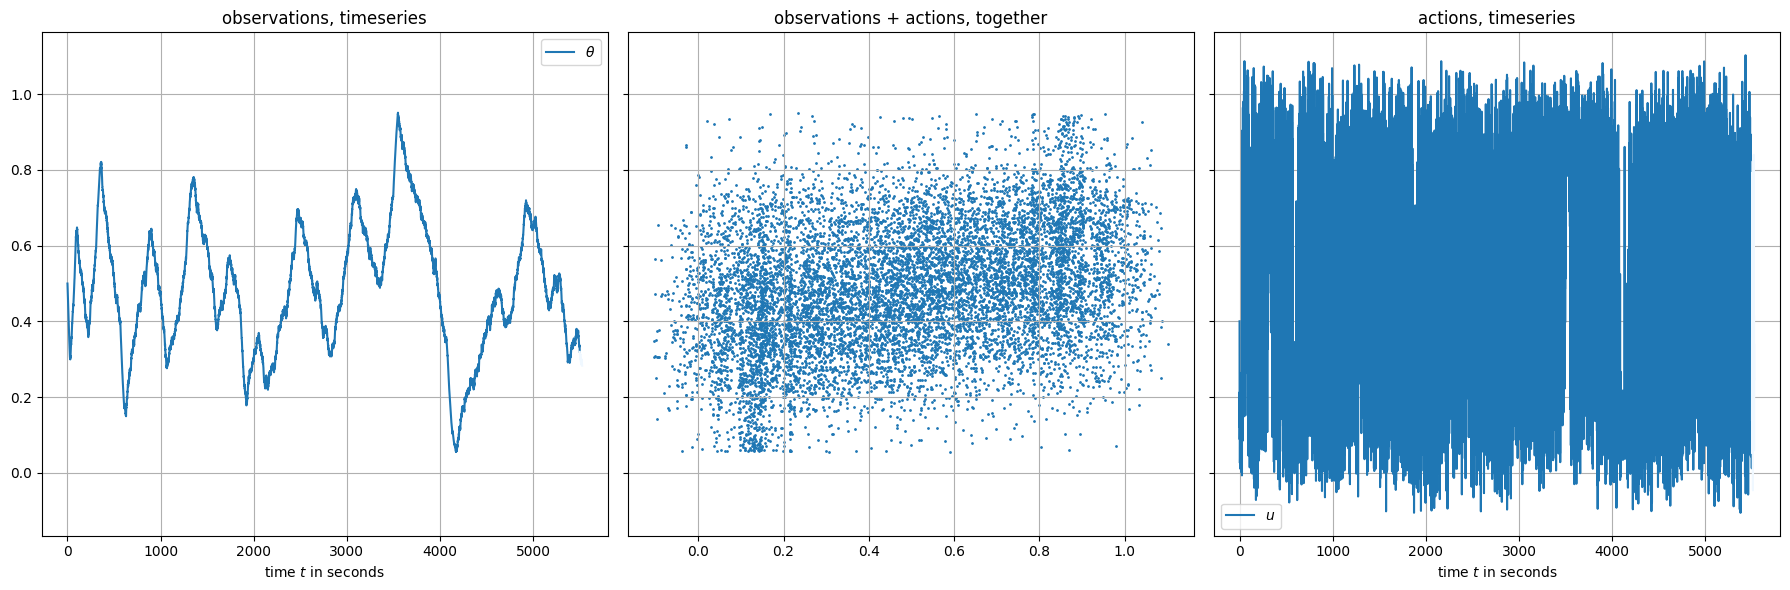

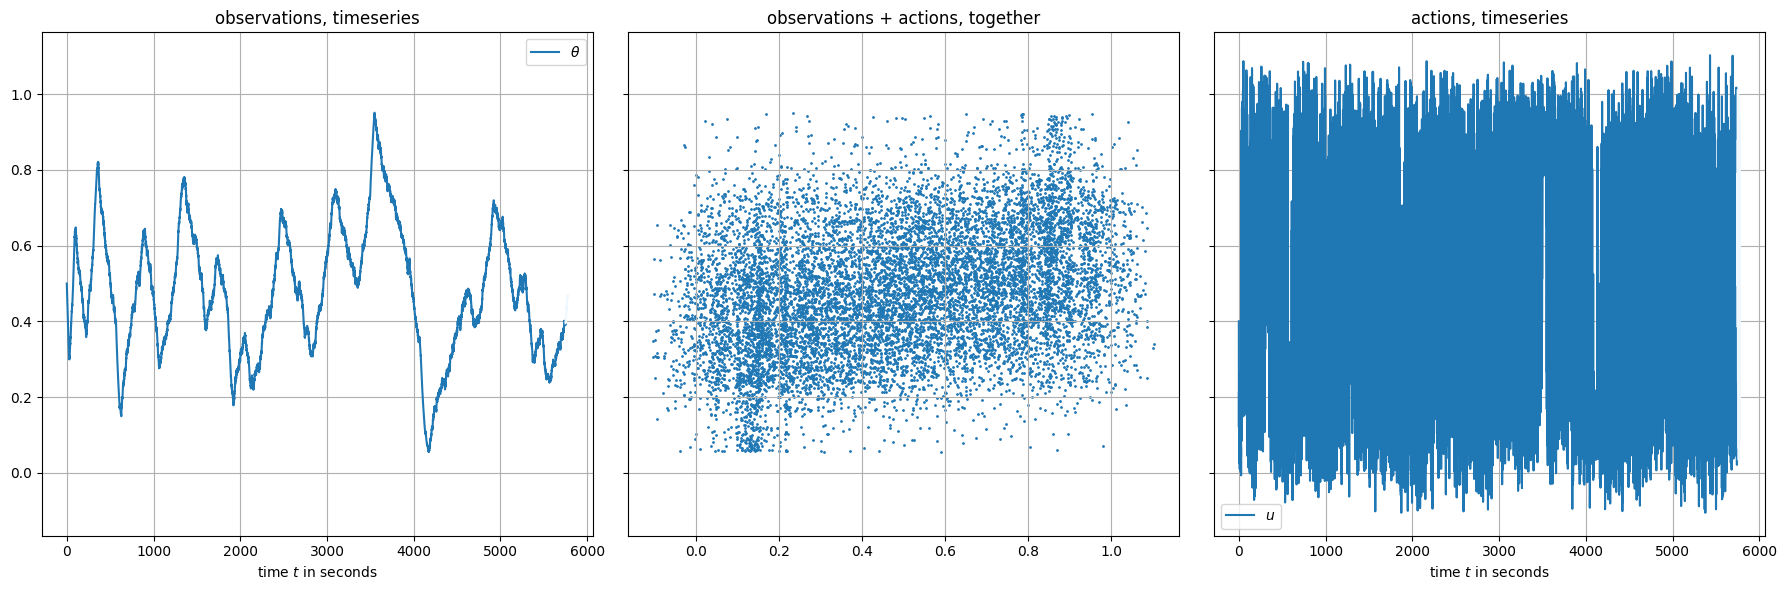

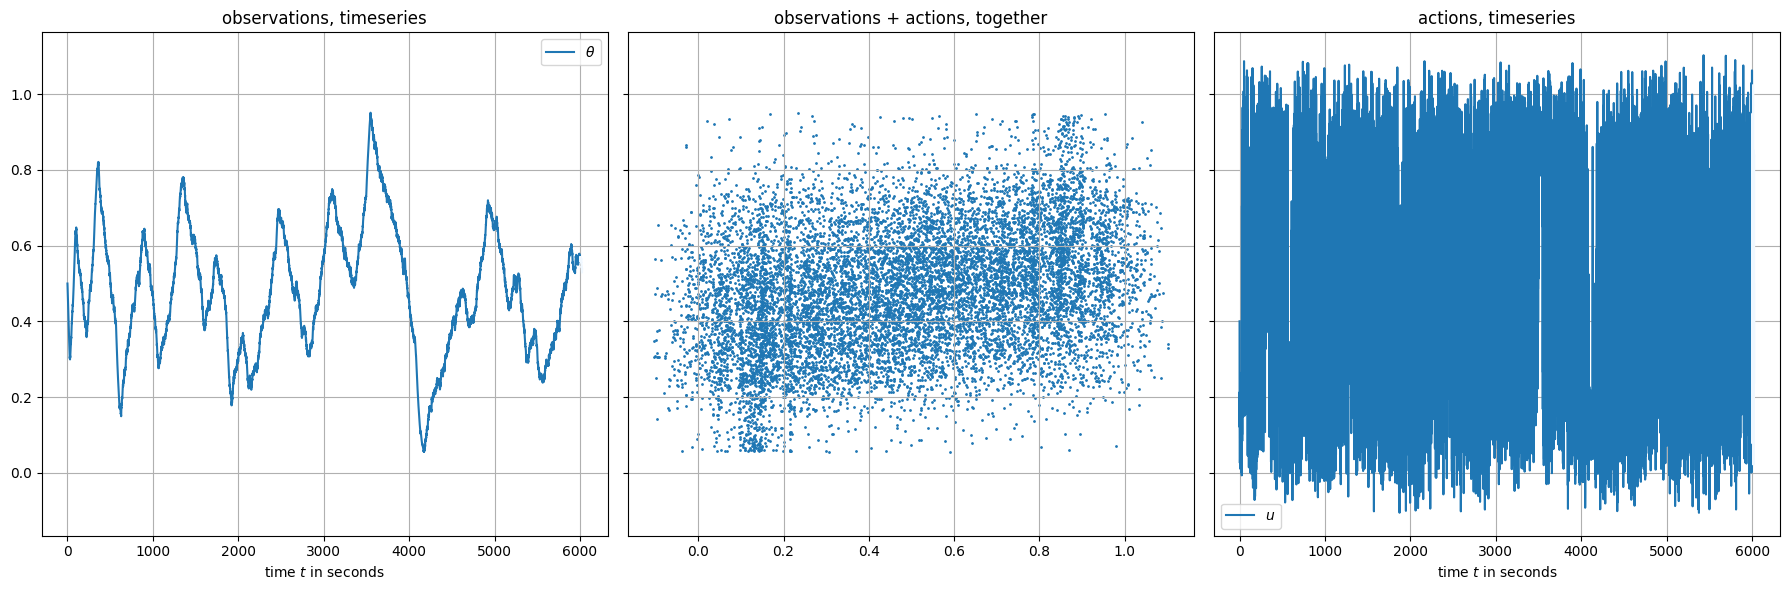

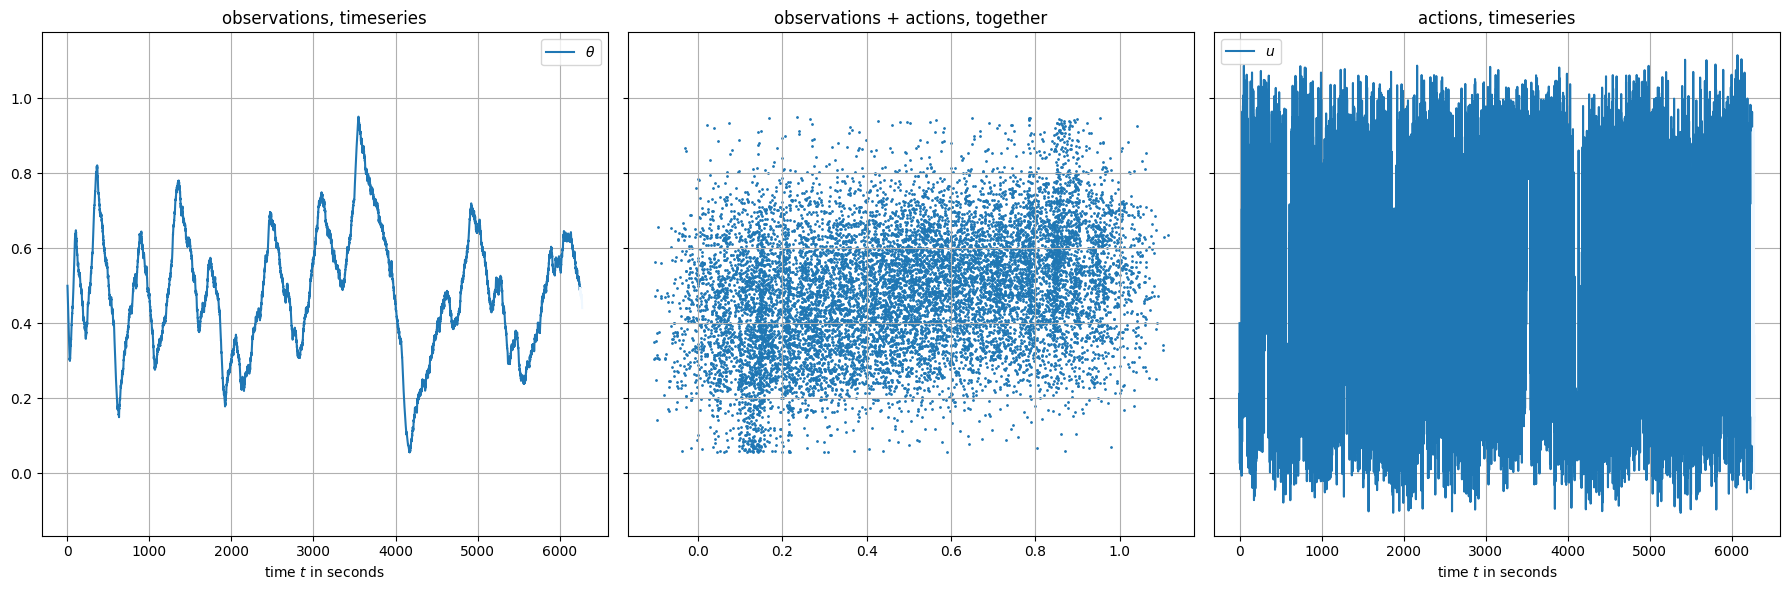

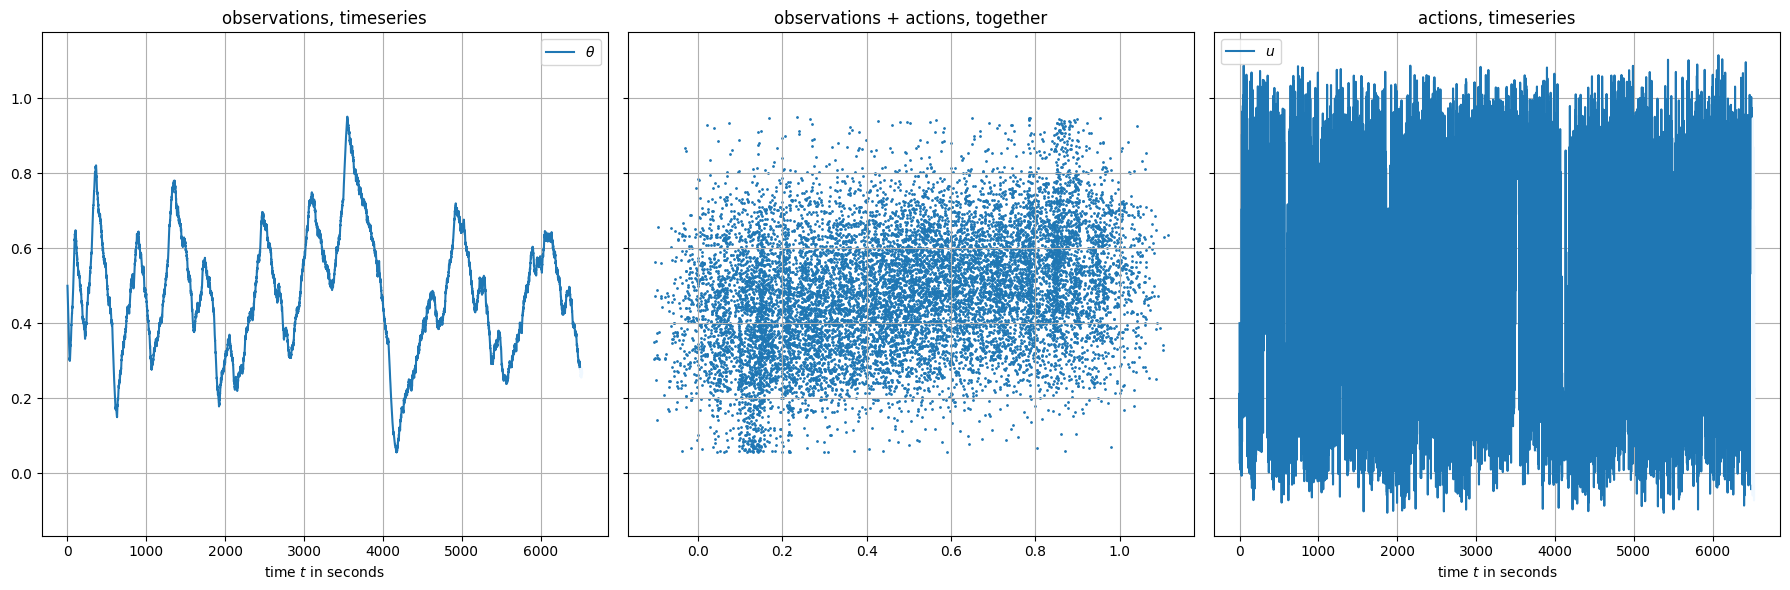

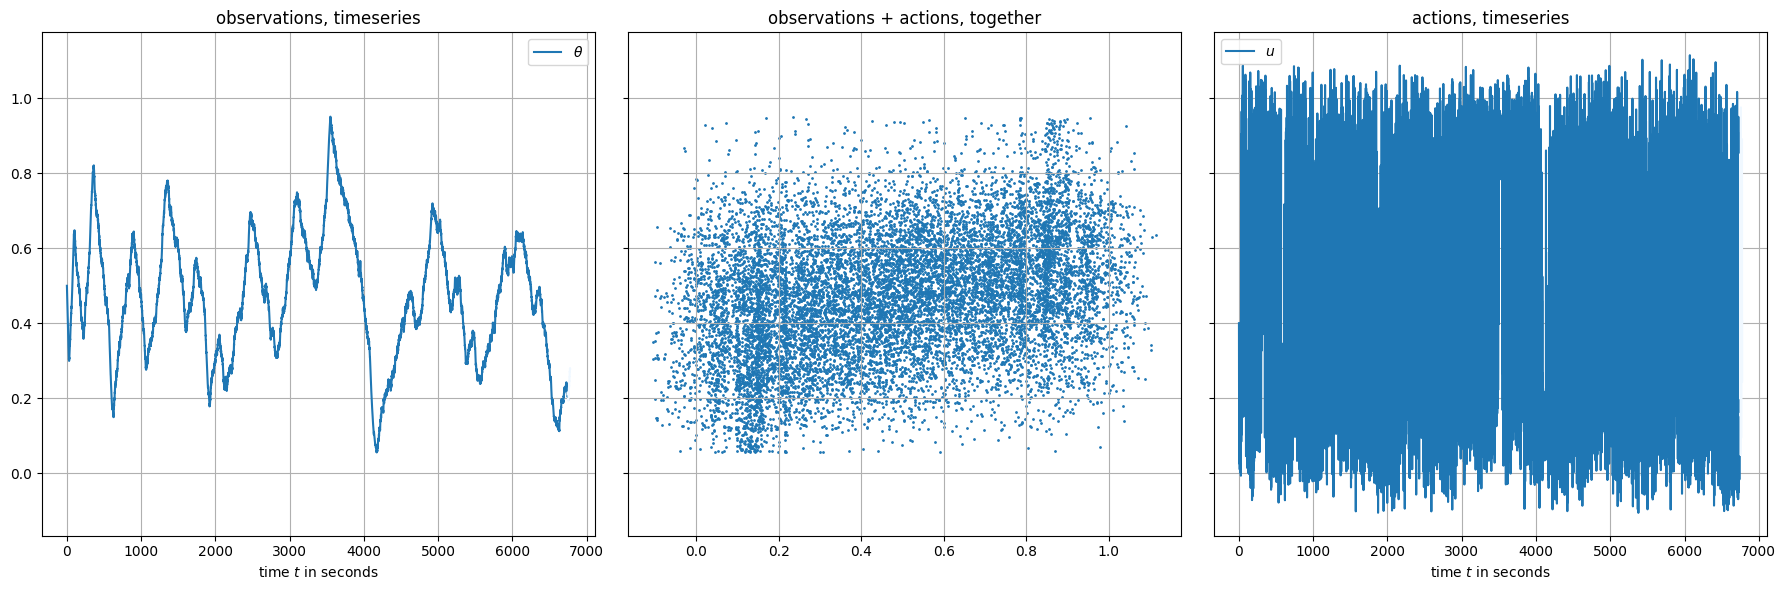

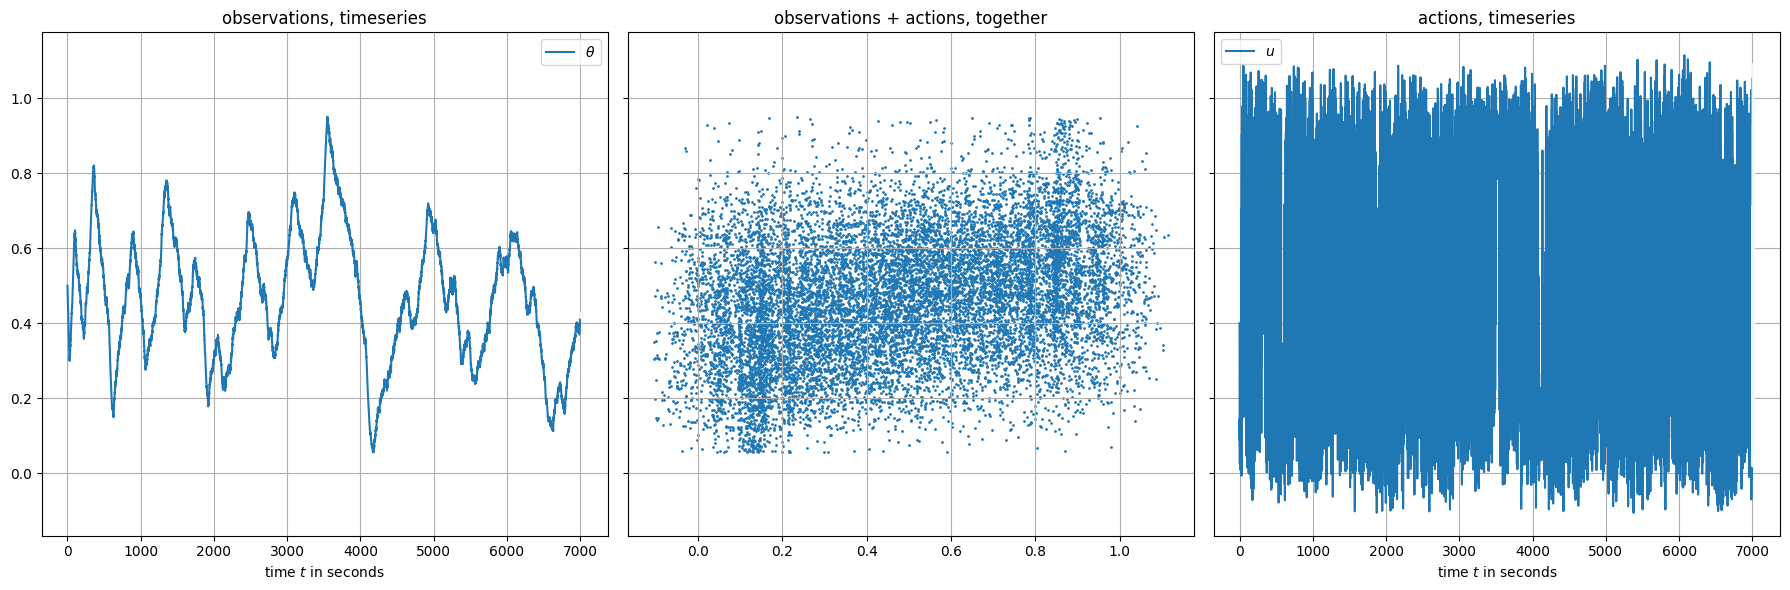

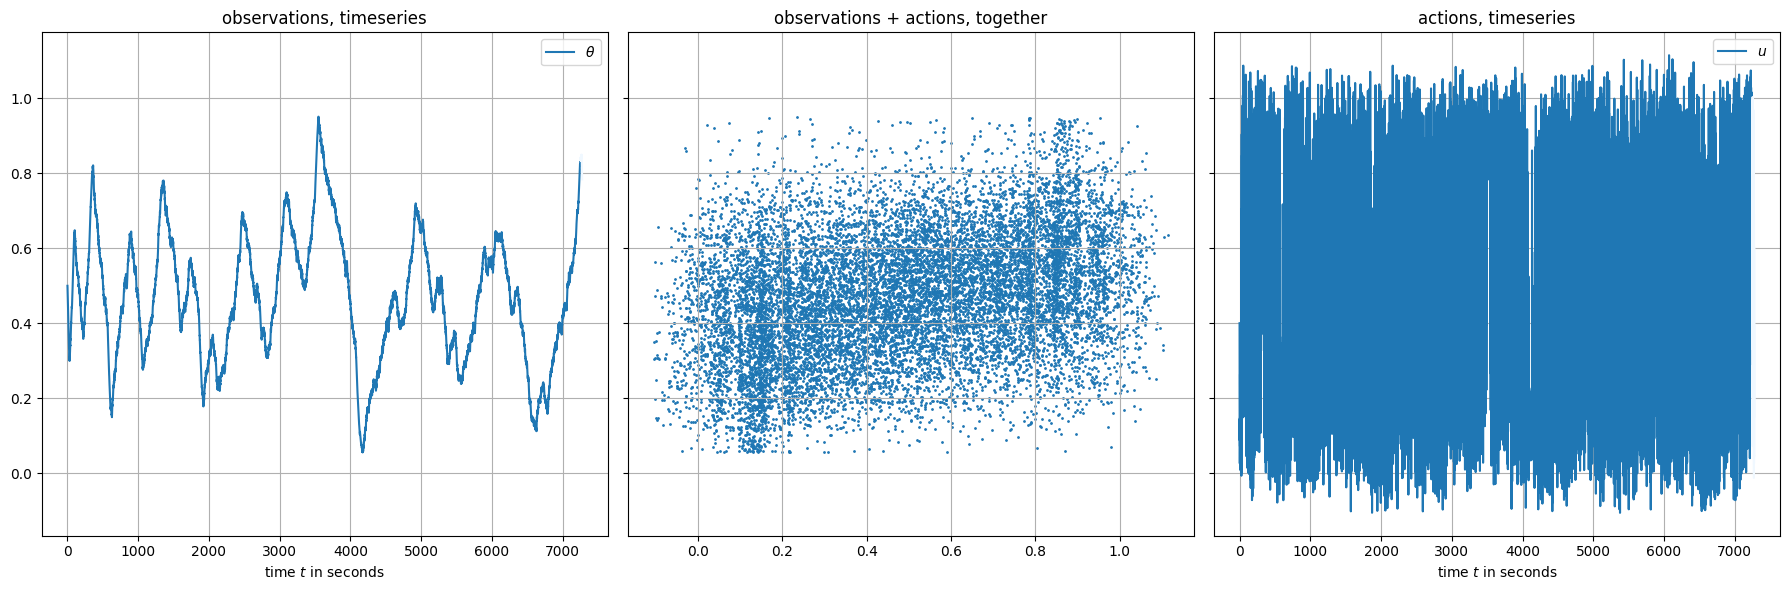

In [43]:
observations, actions, model, density_estimate = excite_and_fit(
    n_timesteps=n_timesteps,
    env=env,
    model=model,
    obs=obs,
    state=state,
    proposed_actions=proposed_actions,
    exciter=exciter,
    model_trainer=model_trainer,
    density_estimate=density_estimate,
    observations=observations,
    actions=actions,
    opt_state_model=opt_state_model,
    loader_key=loader_key
)

[]

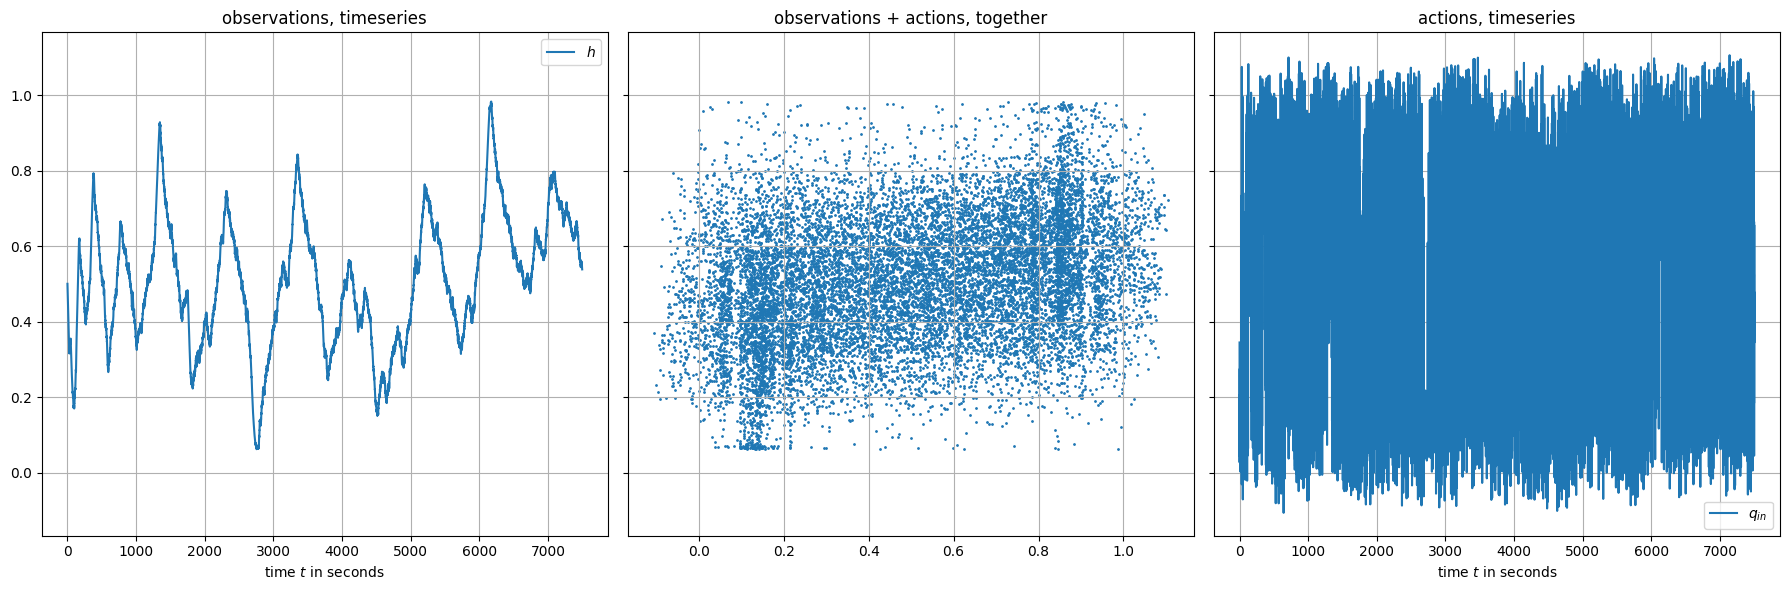

In [15]:
fig, axs = plot_sequence(
    observations,
    actions,
    tau=tau,
    obs_labels=[r"$h$"],
    action_labels=[r"$q_{in}$"]
);
plt.plot()

[]

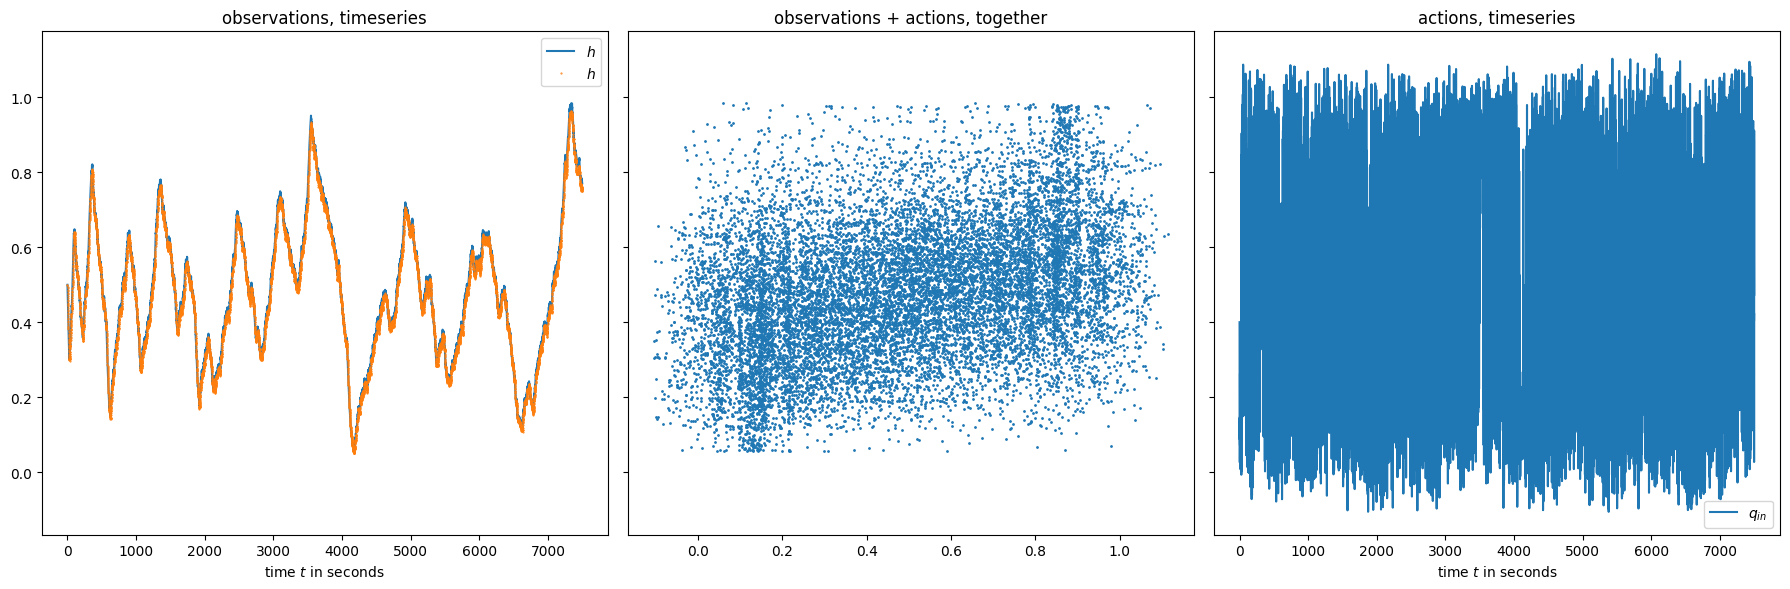

In [44]:
fig, axs = plot_model_performance(
    model=model,
    true_observations=observations,
    actions=actions,
    tau=tau,
    obs_labels=[r"$h$"],
    action_labels=[r"$q_{in}$"]
);
plt.plot()

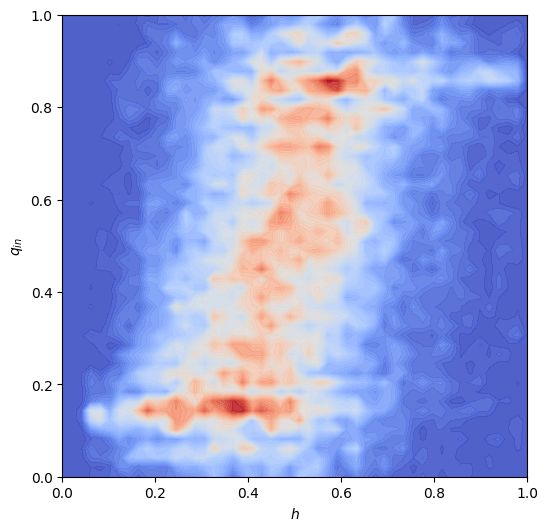

In [45]:
fig, axs, cax = eesys.evaluation.plotting_utils.plot_2d_kde_as_contourf(
    density_estimate.p, density_estimate.x_g, [r"$h$", r"$q_{in}$"]
)

In [46]:
jnp.max(density_estimate.p)

Array(3.8996856, dtype=float32)

In [47]:
grid = eesys.utils.density_estimation.build_grid_2d(0, 1, 50)
df_dt = jax.vmap(model.func)(grid[:, 0], grid[:, 1])

In [48]:
df_dt.shape

(2500, 1)

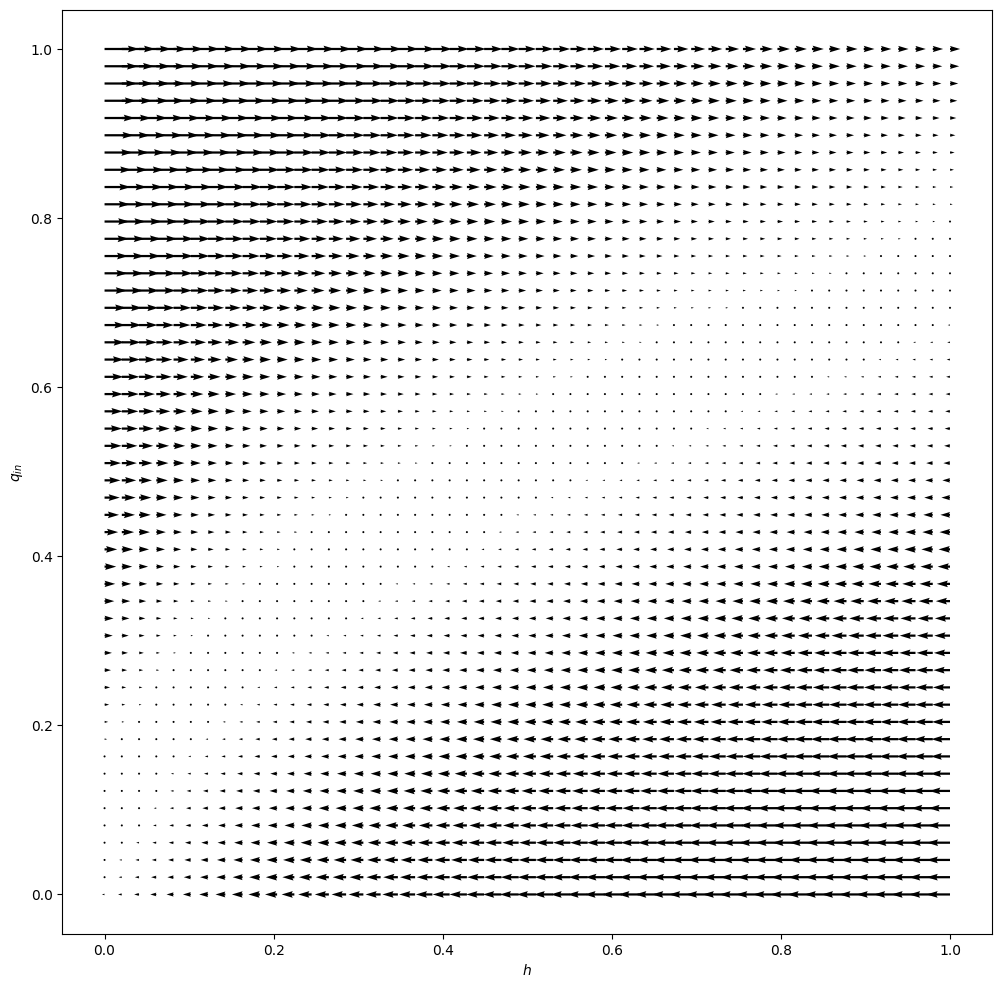

In [49]:
fig, axs = plt.subplots(figsize=(12,12))
axs.quiver(grid[:, 0], grid[:, 1], df_dt, np.zeros(df_dt.shape))
axs.axis('equal')
axs.set_xlabel(r"$h$")
axs.set_ylabel(r"$q_{in}$")
fig.show()

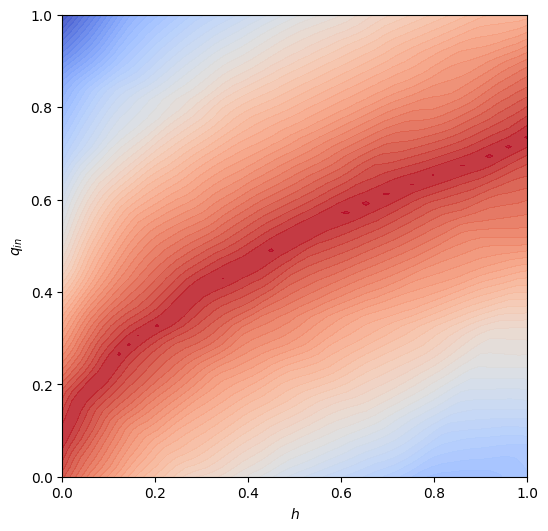

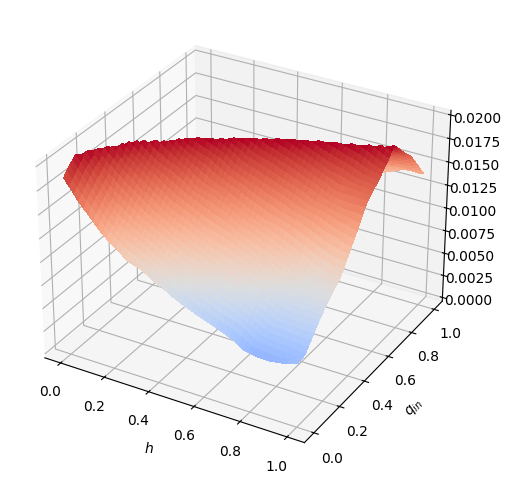

In [50]:
fig, axs, cax = eesys.evaluation.plotting_utils.plot_2d_kde_as_contourf(
   jnp.max(jnp.abs(df_dt)) - jnp.abs(df_dt), grid, [r"$h$", r"$q_{in}$"]
)

fig, axs = eesys.evaluation.plotting_utils.plot_2d_kde_as_surface(
    jnp.max(jnp.abs(df_dt)) - jnp.abs(df_dt), grid, [r"$h$", r"$q_{in}$"]
)

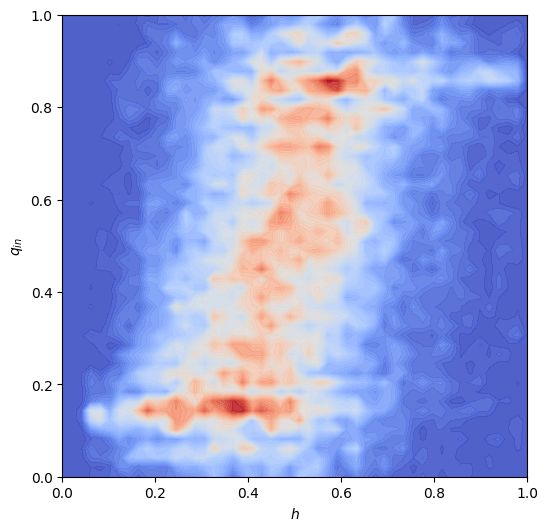

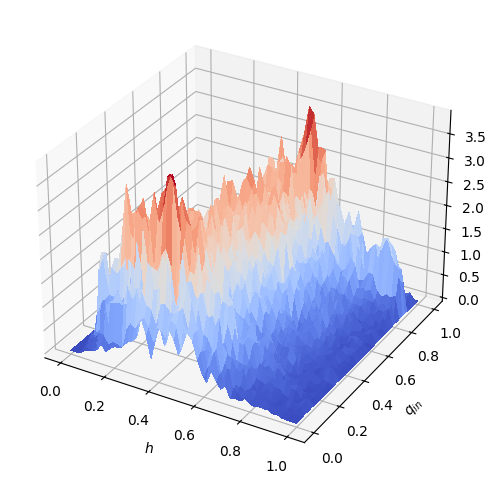

In [51]:
fig, axs, cax = eesys.evaluation.plotting_utils.plot_2d_kde_as_contourf(
    density_estimate.p, density_estimate.x_g, [r"$h$", r"$q_{in}$"]
)

fig, axs = eesys.evaluation.plotting_utils.plot_2d_kde_as_surface(
    density_estimate.p, density_estimate.x_g, [r"$h$", r"$q_{in}$"]
)

- somehow compare this vector field to the kde?
- target distribution could be changed depending on this vector field
- The best way I see is to assume a histogram and normalize the values so that the histogram volume equals to $1$

In [24]:
exciter.target_distribution

Array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [25]:
unnormalized_values = jnp.max(jnp.abs(df_dt)) - jnp.abs(df_dt)

In [26]:
full_area = 1
area_of_each_gridpoint = full_area / 2500

In [27]:
normalization_factor = area_of_each_gridpoint * jnp.sum(unnormalized_values)

In [28]:
pdf_vectorfield = 1 / normalization_factor * unnormalized_values

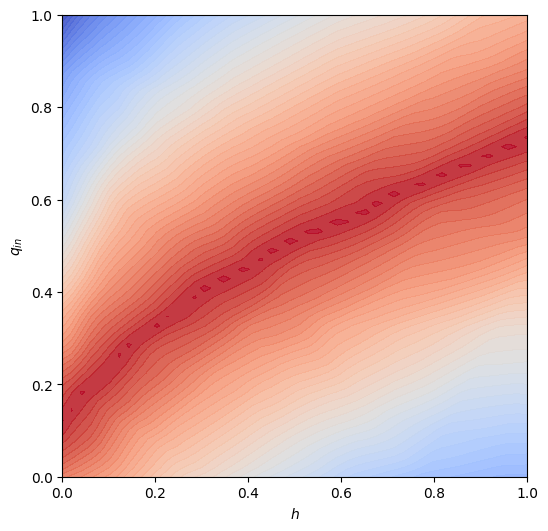

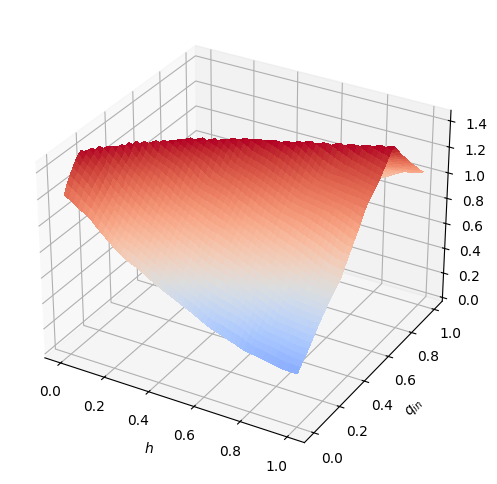

In [29]:
fig, axs, cax = eesys.evaluation.plotting_utils.plot_2d_kde_as_contourf(
    pdf_vectorfield, grid, [r"$h$", r"$q_{in}$"]
)

fig, axs = eesys.evaluation.plotting_utils.plot_2d_kde_as_surface(
    pdf_vectorfield, grid, [r"$h$", r"$q_{in}$"]
)

In [30]:
test_density_estimate = jax.vmap(
    update_density_estimate_single_observation,
    in_axes=(DensityEstimate(0, None, None, None), None),
    out_axes=DensityEstimate(0, None, None, None)
)(density_estimate, jnp.stack([0.2, 0.2]))

In [31]:
for i in range(400):
    test_density_estimate = jax.vmap(
        update_density_estimate_single_observation,
        in_axes=(DensityEstimate(0, None, None, None), None),
        out_axes=DensityEstimate(0, None, None, None)
    )(test_density_estimate, jnp.stack([0.2, 0.2]))

In [32]:
test_density_estimate.x_g.shape

(2500, 2)

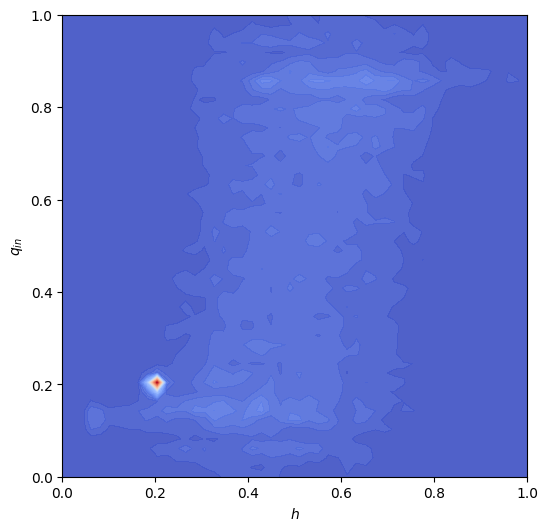

In [33]:
fig, axs, cax = eesys.evaluation.plotting_utils.plot_2d_kde_as_contourf(
    test_density_estimate.p, test_density_estimate.x_g, [r"$h$", r"$q_{in}$"]
)

In [34]:
exciter.target_distribution.shape
density_estimate.p.shape

(1, 2500, 1)

In [35]:
eesys.utils.metrics.JSDLoss(density_estimate.p[0], exciter.target_distribution)

Array(2851.7952, dtype=float32)

In [36]:
eesys.utils.metrics.JSDLoss(test_density_estimate.p[0], exciter.target_distribution)

Array(2930.7832, dtype=float32)

In [37]:
jnp.max(density_estimate.p[0])

Array(4.951842, dtype=float32)

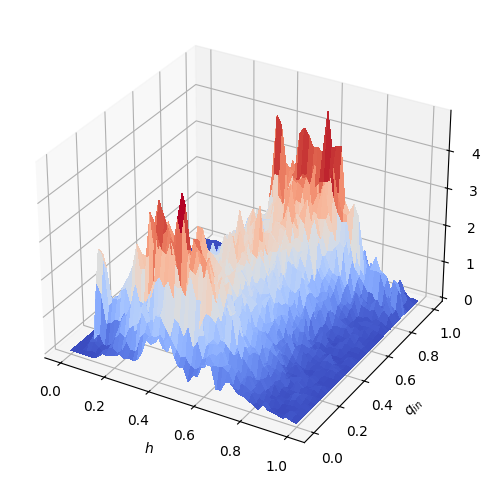

In [38]:
fig, axs = eesys.evaluation.plotting_utils.plot_2d_kde_as_surface(
    density_estimate.p, density_estimate.x_g, [r"$h$", r"$q_{in}$"]
)